In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='portex_nolegend-xception-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [ ]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.1270
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 142s - loss: 0.4089 - acc: 0.8872 - val_loss: 0.4658 - val_acc: 0.8906
Epoch 2/100
9112/9112 [==============================] - 138s - loss: 0.1813 - acc: 0.9489 - val_loss: 0.3159 - val_acc: 0.9189
Epoch 3/100
9112/9112 [==============================] - 137s - loss: 0.1296 - acc: 0.9633 - val_loss: 0.3272 - val_acc: 0.9189
Epoch 4/100
9112/9112 [==============================] - 138s - loss: 0.1030 - acc: 0.9712 - val_loss: 0.2140 - val_acc: 0.9443
Epoch 5/100
9112/9112 [==============================] - 138s - loss: 0.0825 - acc: 0.9751 - val_loss: 0.2741 - val_acc: 0.9424
Epoch 6/100
9112/9112 [==============================] - 136s - loss: 0.0632 - acc: 0.9808 - val_loss: 0.3123 - val_acc: 0.9238
Epoch 7/100
9112/9112 [==============================] - 137s - loss: 0.0574 - acc: 0.9820 - val_loss: 0.3970 - val_acc: 0.9160
Epoch 8/100
9112/9112 [====

9116/9116 [==============================] - 135s - loss: 0.0044 - acc: 0.9987 - val_loss: 0.3176 - val_acc: 0.9559
Epoch 54/100
9116/9116 [==============================] - 137s - loss: 0.0037 - acc: 0.9991 - val_loss: 0.2913 - val_acc: 0.9549
Epoch 55/100
9116/9116 [==============================] - 137s - loss: 0.0099 - acc: 0.9974 - val_loss: 0.6034 - val_acc: 0.8922
Epoch 56/100
9116/9116 [==============================] - 137s - loss: 0.0205 - acc: 0.9931 - val_loss: 0.3819 - val_acc: 0.9402
Epoch 57/100
9116/9116 [==============================] - 141s - loss: 0.0127 - acc: 0.9966 - val_loss: 0.4249 - val_acc: 0.9314
Epoch 58/100
9116/9116 [==============================] - 137s - loss: 0.0086 - acc: 0.9974 - val_loss: 0.2799 - val_acc: 0.9559
Epoch 59/100
9116/9116 [==============================] - 144s - loss: 0.0045 - acc: 0.9987 - val_loss: 0.2777 - val_acc: 0.9598
Epoch 60/100
9116/9116 [==============================] - 144s - loss: 0.0091 - acc: 0.9974 - val_loss: 0.2986

9120/9120 [==============================] - 139s - loss: 0.0249 - acc: 0.9921 - val_loss: 0.3602 - val_acc: 0.9341
Epoch 16/100
9120/9120 [==============================] - 138s - loss: 0.0310 - acc: 0.9890 - val_loss: 0.3800 - val_acc: 0.9360
Epoch 17/100
9120/9120 [==============================] - 140s - loss: 0.0265 - acc: 0.9919 - val_loss: 0.7084 - val_acc: 0.8553
Epoch 18/100
9120/9120 [==============================] - 137s - loss: 0.0298 - acc: 0.9902 - val_loss: 0.3961 - val_acc: 0.9360
Epoch 19/100
9120/9120 [==============================] - 140s - loss: 0.0291 - acc: 0.9914 - val_loss: 0.3388 - val_acc: 0.9341
Epoch 20/100
9120/9120 [==============================] - 139s - loss: 0.0094 - acc: 0.9971 - val_loss: 0.3301 - val_acc: 0.9429
Epoch 21/100
9120/9120 [==============================] - 138s - loss: 0.0179 - acc: 0.9942 - val_loss: 1.2048 - val_acc: 0.8356
Epoch 22/100
9120/9120 [==============================] - 140s - loss: 0.0232 - acc: 0.9931 - val_loss: 0.3101

9127/9127 [==============================] - 144s - loss: 0.0081 - acc: 0.9981 - val_loss: 0.2240 - val_acc: 0.9554
Epoch 24/100
9127/9127 [==============================] - 144s - loss: 0.0100 - acc: 0.9973 - val_loss: 0.2456 - val_acc: 0.9524
Epoch 25/100
9127/9127 [==============================] - 145s - loss: 0.0204 - acc: 0.9941 - val_loss: 0.4272 - val_acc: 0.9316
Epoch 26/100
9127/9127 [==============================] - 144s - loss: 0.0527 - acc: 0.9855 - val_loss: 0.3487 - val_acc: 0.9386
Epoch 27/100
9127/9127 [==============================] - 147s - loss: 0.0184 - acc: 0.9942 - val_loss: 0.1818 - val_acc: 0.9584
Epoch 28/100
9127/9127 [==============================] - 144s - loss: 0.0091 - acc: 0.9978 - val_loss: 0.2052 - val_acc: 0.9623
Epoch 29/100
9127/9127 [==============================] - 144s - loss: 0.0167 - acc: 0.9953 - val_loss: 0.3225 - val_acc: 0.9336
Epoch 30/100
9127/9127 [==============================] - 144s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.2227

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9591


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

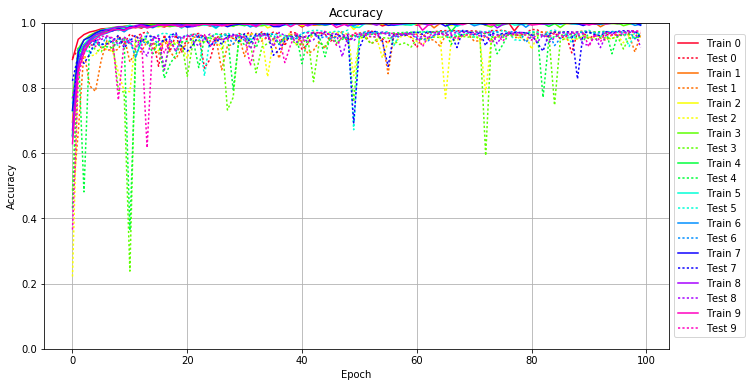

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

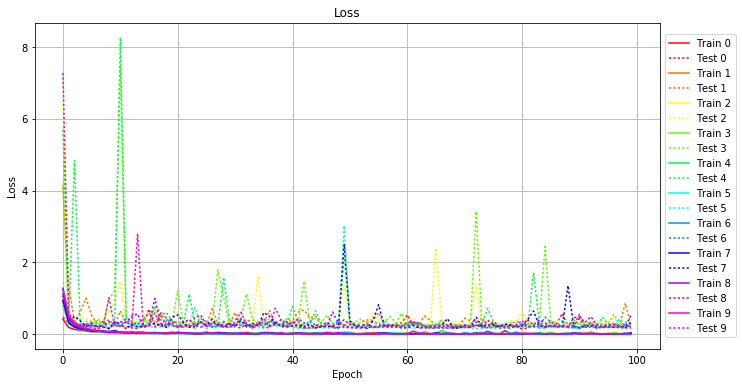

In [ ]:
plot_loss(history)

Plotting the confusion matrix


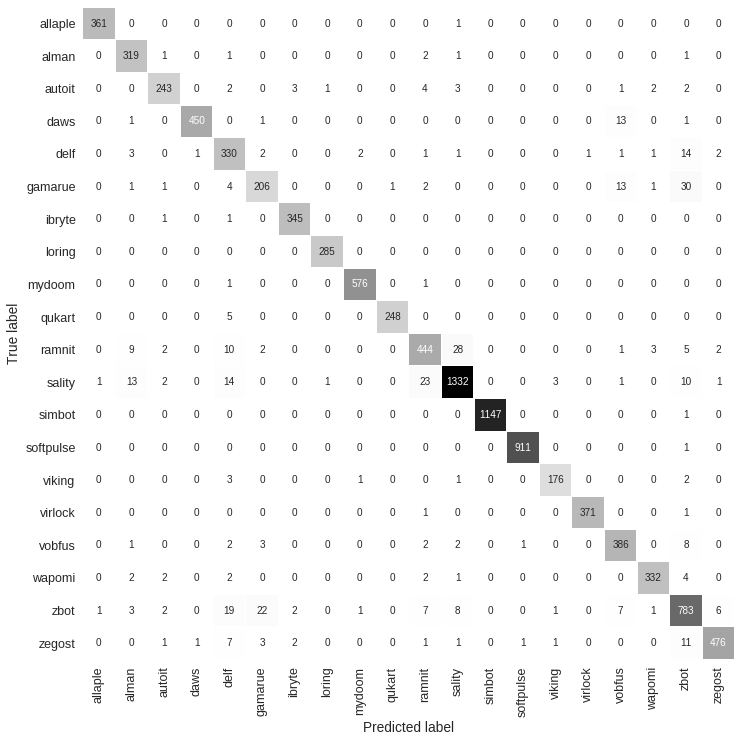

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


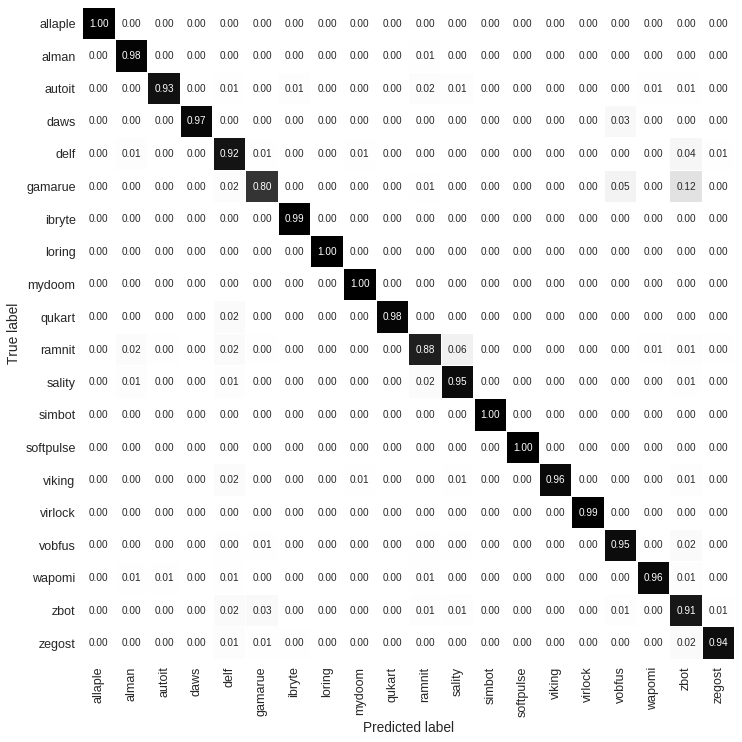

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'acc': [0.88718173836698855, 0.94885864804144804, 0.9633450395606713, 0.97124670769060983, 0.97508779631255482, 0.98079455673328297, 0.98200175592625105, 0.98331870071923555, 0.98364793678665496, 0.98847673408183434, 0.98858647936786659, 0.98880597014925375, 0.98298946444249347, 0.9915496049165935, 0.99363476733977174, 0.99067164179104472, 0.98661106233538187, 0.99385425812115891, 0.9918788410886743, 0.98726953467954348, 0.98979367866549606, 0.99506145741878838, 0.99824407374890256, 0.99462247585601404, 0.98968393327480242, 0.99176909569798066, 0.99561018437225635, 0.9996707638279192, 0.99056189640035119, 0.99495171202809485, 0.99736611062335379, 0.99747585601404742, 0.99297629510027152, 0.99297629499561013, 0.99626865671641796, 0.99495171202809485, 0.99813432841053962, 0.99604916593503068, 0.9990122914837577, 0.99802458296751539, 0.98661106233538187, 0.99659789288849865, 0.99725636523266026, 0.99890254609306406, 0.99912203687445122, 0.99703687445127309, 0.99429323968393324, 0.9983538

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

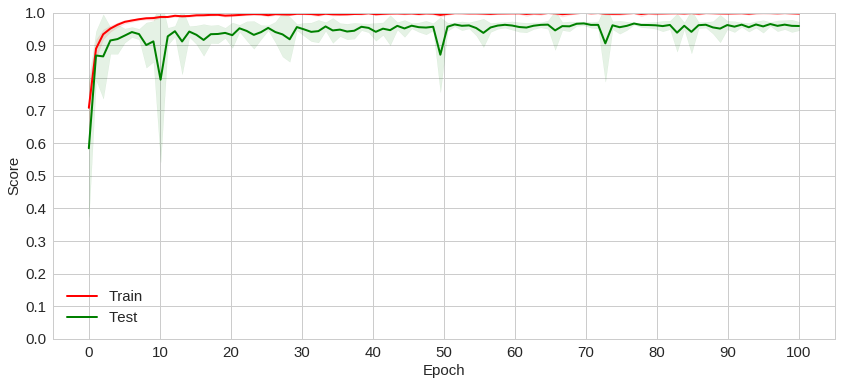

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

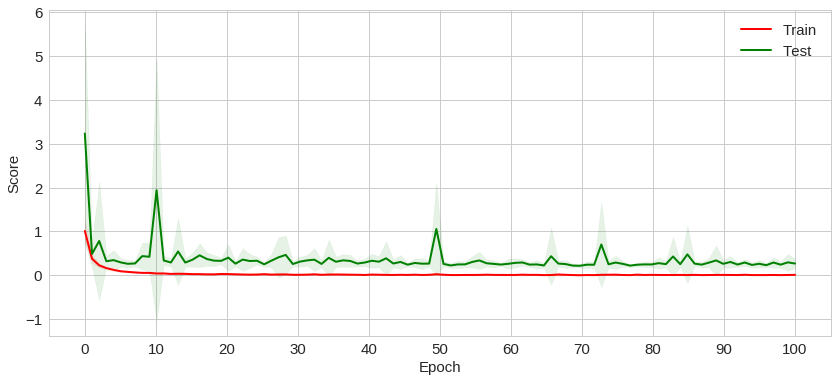

In [ ]:
plot_mean_loss(history)

In [25]:
hist = [{'acc': [0.88718173836698855, 0.94885864804144804, 0.9633450395606713, 0.97124670769060983, 0.97508779631255482, 0.98079455673328297, 0.98200175592625105, 0.98331870071923555, 0.98364793678665496, 0.98847673408183434, 0.98858647936786659, 0.98880597014925375, 0.98298946444249347, 0.9915496049165935, 0.99363476733977174, 0.99067164179104472, 0.98661106233538187, 0.99385425812115891, 0.9918788410886743, 0.98726953467954348, 0.98979367866549606, 0.99506145741878838, 0.99824407374890256, 0.99462247585601404, 0.98968393327480242, 0.99176909569798066, 0.99561018437225635, 0.9996707638279192, 0.99056189640035119, 0.99495171202809485, 0.99736611062335379, 0.99747585601404742, 0.99297629510027152, 0.99297629499561013, 0.99626865671641796, 0.99495171202809485, 0.99813432841053962, 0.99604916593503068, 0.9990122914837577, 0.99802458296751539, 0.98661106233538187, 0.99659789288849865, 0.99725636523266026, 0.99890254609306406, 0.99912203687445122, 0.99703687445127309, 0.99429323968393324, 0.99835381913959609, 0.99209833187006147, 0.99890254609306406, 0.99945127304653203, 0.9996707638279192, 0.9996707638279192, 0.99956101843722567, 0.98979367877015745, 0.99539069359086918, 0.99593942054433715, 0.9990122914837577, 0.99912203687445122, 0.99923178226514486, 0.99198858647936783, 0.99571992976294998, 0.99923178226514486, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.97464881474978049, 0.99670763827919229, 0.99956101843722567, 0.99989025460930636, 0.99978050921861283, 0.99736611062335379, 0.99846356453028973, 0.99835381913959609, 0.9990122914837577, 0.99736611062335379, 0.99670763827919229, 0.99791483757682176, 0.99978050921861283, 0.99956101843722567, 0.99550043898156282, 0.99648814749780512, 0.99857330992098337, 0.99912203697911262, 0.99692712906057945, 0.99868305531167689, 0.99912203687445122, 0.9993415276558385, 0.99945127304653203], 'loss': [0.40894925806269089, 0.18126274730365877, 0.12955797511243683, 0.10299078088243106, 0.082484960757585157, 0.063190477652045149, 0.057434492430725743, 0.054868746520885976, 0.056015903597265888, 0.033810108177303774, 0.035251455401596583, 0.036091128239178982, 0.066394403001979976, 0.027121933759982259, 0.018121645794734742, 0.033906721834792077, 0.045231802960370417, 0.023778248287067292, 0.024137284439488687, 0.042391667758788498, 0.036099153891266805, 0.018418033326722986, 0.0056149551313189701, 0.016281504595653411, 0.033302313314754216, 0.026239359595988616, 0.016880343669432443, 0.0020092202446399029, 0.032373460902429825, 0.017837232639851354, 0.0077112413091814293, 0.0097298601067610062, 0.022457027561121546, 0.023165616263755635, 0.013061097428076837, 0.019023022872489182, 0.0067009924492743541, 0.01451067441771728, 0.0058216084514439766, 0.0069033643545314142, 0.040538776047634076, 0.01078996144867574, 0.010276260061816683, 0.0033807840946831294, 0.0022703428175992919, 0.011478284481329964, 0.021529489907799897, 0.0052584228573003145, 0.026426944550413944, 0.0042181361219879284, 0.0027373722534458972, 0.0027132070802994169, 0.0016271895057555802, 0.001470254279217628, 0.037462866099328293, 0.016239731938227607, 0.012346574915780357, 0.0032773711564258296, 0.0029472065157606234, 0.0022284013435614307, 0.02941142795817989, 0.014134640735333878, 0.0037148854103950029, 0.0012345506194250126, 0.00068839440822786432, 0.00071094536539395743, 0.00062535474337083998, 0.00056173978103933586, 0.00058423178524534785, 0.00053730092437070367, 0.00072614938948237261, 0.00066248548131427856, 0.00080222406598918724, 0.0010972781780787277, 0.00069218175502768224, 0.00055015489840291333, 0.00056476227651229289, 0.092168221719424098, 0.010675461125250337, 0.0020167466052047485, 0.0010155578022351367, 0.0012150206338018381, 0.011072064804251412, 0.0047753061099886111, 0.0084557560195340324, 0.0044714656122159116, 0.0086593434018454145, 0.009737984266386366, 0.0071033263631945414, 0.0010572657251759405, 0.0020920076619039712, 0.0184597085036271, 0.012842318005001413, 0.0038539475102022614, 0.0029217019242578214, 0.014783706591209086, 0.0042803984747754745, 0.0036897683019674831, 0.0024908016349728169, 0.0018741745866645203], 'val_acc': [0.890625, 0.9189453125, 0.9189453125, 0.9443359375, 0.9423828125, 0.923828125, 0.916015625, 0.916015625, 0.9609375, 0.9345703125, 0.96484375, 0.9541015625, 0.966796875, 0.9716796875, 0.9521484375, 0.8662109375, 0.962890625, 0.912109375, 0.962890625, 0.908203125, 0.9541015625, 0.9638671875, 0.966796875, 0.8603515625, 0.888671875, 0.951171875, 0.9658203125, 0.9638671875, 0.951171875, 0.966796875, 0.962890625, 0.970703125, 0.955078125, 0.9716796875, 0.9609375, 0.970703125, 0.96484375, 0.9287109375, 0.9716796875, 0.9677734375, 0.9169921875, 0.935546875, 0.970703125, 0.96875, 0.96484375, 0.943359375, 0.9609375, 0.9716796875, 0.9375, 0.9677734375, 0.9677734375, 0.970703125, 0.9765625, 0.9599609375, 0.9501953125, 0.9375, 0.9658203125, 0.966796875, 0.96484375, 0.955078125, 0.923828125, 0.95703125, 0.96875, 0.9716796875, 0.974609375, 0.9755859375, 0.9755859375, 0.9755859375, 0.97265625, 0.974609375, 0.974609375, 0.97265625, 0.96484375, 0.9755859375, 0.9755859375, 0.9765625, 0.9716796875, 0.962890625, 0.9609375, 0.9677734375, 0.9794921875, 0.9775390625, 0.96875, 0.958984375, 0.9697265625, 0.9501953125, 0.9619140625, 0.9072265625, 0.9716796875, 0.9697265625, 0.9501953125, 0.9638671875, 0.9580078125, 0.962890625, 0.962890625, 0.9619140625, 0.9599609375, 0.96875, 0.9736328125, 0.9677734375], 'val_loss': [0.46583204997675409, 0.31590384709988939, 0.32715168154805951, 0.21403247353396226, 0.27411535255089481, 0.31233300750167814, 0.39700837606332584, 0.33266911294188617, 0.15775491834062905, 0.31521964824514725, 0.21633750159082865, 0.20877461406222686, 0.16967930102748996, 0.15658413803080995, 0.2976980903520392, 0.69188502311411249, 0.19099675176818964, 0.57930730463279545, 0.22366003441775639, 0.39185539575646544, 0.21973873290153723, 0.23157941974536467, 0.20727603292044705, 0.45440902930886296, 0.5292864640117334, 0.25047162786702026, 0.19850748830626941, 0.24367883199597751, 0.2465903893893695, 0.19243586892360653, 0.20995696541063191, 0.16599452093827471, 0.306170945520432, 0.16706840609525297, 0.29630793101781849, 0.16774788518717587, 0.18195156707981486, 0.37816803103283547, 0.1824522982933261, 0.24639352008877413, 0.33592099339803205, 0.36138723505822501, 0.17522825027131228, 0.16616147718434915, 0.21958882305853944, 0.31556334507148343, 0.22411724260687738, 0.19887982785299396, 0.31951443464517748, 0.17181153848255803, 0.1843721488758594, 0.17426156721226072, 0.17313883580331613, 0.32190708796122625, 0.34587419286199639, 0.28789835371674011, 0.20788374247638508, 0.23565421946569431, 0.27772288002080359, 0.30993059635992815, 0.53120313464274638, 0.25026771884364329, 0.16509061473862463, 0.17408695442934574, 0.17095765534456886, 0.1658580590766201, 0.16878796380665007, 0.16360317156297022, 0.17757270042341533, 0.17772471807076107, 0.18146529384932597, 0.18358517732892476, 0.33854522407611842, 0.17690563771133583, 0.18013407422603933, 0.18675104639073181, 0.20297508306136613, 0.21609053546107226, 0.25494593187517545, 0.20978985636142866, 0.14141168109241375, 0.16512947881748508, 0.22650349830469008, 0.26236934450990601, 0.2140693288336486, 0.35713670243810292, 0.27646963543451619, 0.57551243589944834, 0.22084198212112582, 0.23654382136263896, 0.4318816427250165, 0.21501174343948337, 0.2563930759356805, 0.24238911441548971, 0.27246720411791392, 0.20915284267412515, 0.29463756212893788, 0.21824118221415878, 0.17700211082484874, 0.22205721464170702]},
{'acc': [0.69497476424306581, 0.87480798773737312, 0.92330480598948206, 0.93691024806171441, 0.96050032934704077, 0.96741277165179562, 0.97256967303050257, 0.97640991889779072, 0.97816545973227997, 0.9874917709019092, 0.99177090190915074, 0.98474873829651799, 0.98595567268317585, 0.99385560675883255, 0.99451393460610049, 0.98880842659644508, 0.99056396752249287, 0.98771121351766511, 0.99231950844854067, 0.99297783638736725, 0.99352644292675718, 0.99253895106429668, 0.99802501645819619, 0.99780557384244017, 0.99506254114549042, 0.99210006583278476, 0.99155145948959178, 0.99100285275400479, 0.99451393460610049, 0.99473337722185651, 0.99440421329822248, 0.99550142637700245, 0.99714724599517224, 0.99703752477885288, 0.99539170506912444, 0.99714724599517224, 0.99122229536976081, 0.99572086899275836, 0.99956111476848808, 0.99956111476848808, 0.99901250822909804, 0.99912222953697605, 0.9921000659243433, 0.99341672152732063, 0.99407504937458857, 0.99692780337941633, 0.99802501645819619, 0.99736668861092825, 0.99736668861092825, 0.99659863945578231, 0.99769585253456217, 0.99857362299758612, 0.99484309852973452, 0.99495281983761241, 0.99561114768488035, 0.99330700021944263, 0.99846390168970811, 0.99901250822909804, 0.99901250822909804, 0.99956111476848808, 0.99978055738424398, 0.99967083607636598, 0.99956111476848808, 0.98398068904981351, 0.99725696730305025, 0.99758613122668427, 0.99681808207153833, 0.99934167215273206, 0.99890278692122014, 0.99967083607636598, 0.99956111476848808, 0.99802501645819619, 0.9927583936800527, 0.99539170506912444, 0.99890278692122014, 0.99824445907395221, 0.99901250822909804, 0.99868334430546413, 0.99594031160851437, 0.99670836076366032, 0.9946236559139785, 0.99912222953697605, 0.99956111476848808, 0.99978055738424398, 0.99978055738424398, 0.99967083607636598, 0.99978055738424398, 0.99967083607636598, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99967083607636598, 0.9873820495940312, 0.99670836076366032, 0.99824445907395221, 0.99868334430546413, 0.99879306561334213, 0.99835418047338875, 0.99846390168970811, 0.9981347377660742], 'loss': [1.0568407048435098, 0.43580387857417041, 0.25901477690561314, 0.20199780750162172, 0.13828591322078762, 0.10833360707489105, 0.088770814095283507, 0.075282569103628003, 0.066710922718506913, 0.04095444616256496, 0.028162911531805831, 0.047714688643504123, 0.043776698226933995, 0.020907799865161874, 0.01877154818202504, 0.037441375704299493, 0.031614579046933954, 0.036604262233266453, 0.024750716935069476, 0.02101373280620189, 0.022808721535089605, 0.024811680120746454, 0.0068020273226420385, 0.0058598579205676833, 0.016903956249711468, 0.025544624516319385, 0.026475386116135598, 0.030234351589745828, 0.016186792336604403, 0.013105605647507634, 0.017446990587879335, 0.013725401642463574, 0.010757559241686325, 0.0095137199631474059, 0.017191889230717541, 0.010182931328654795, 0.031369777769261628, 0.012985478919308834, 0.0026630456261713567, 0.0024654632900212776, 0.0031097631329703671, 0.0038214658384463454, 0.025316974755164236, 0.022094708613715264, 0.021700497055442462, 0.011628821135751442, 0.0055925853580230892, 0.0076212347831671086, 0.0088455201238394551, 0.01262544108905795, 0.0070717558287037635, 0.0059789945174230147, 0.015570384647336762, 0.014603594535471153, 0.013637534218036174, 0.018996948889019052, 0.0041839630221059861, 0.0036906253584838202, 0.0033537484734245822, 0.0016616106156981348, 0.0011985549134968267, 0.0010053468086960889, 0.0015382154417714982, 0.059271930560593732, 0.01012702156676069, 0.0085782149458736266, 0.0095562079857655045, 0.0032957746947308245, 0.0035280999102951633, 0.0017327807951951144, 0.0016053879595857628, 0.0078060489959039083, 0.021648721730736401, 0.013261193036555522, 0.0038759031397042369, 0.0060095958197432025, 0.0029467764920930459, 0.0034596227172937581, 0.015300103099846574, 0.012141135238329735, 0.017110838191556513, 0.0048794019104628824, 0.0025181735195219709, 0.0012997966178355139, 0.0011005128275115488, 0.00082138029935711345, 0.0010734948566371758, 0.0011150462603214889, 0.00096844268188661317, 0.00089385107457050665, 0.001080982466970695, 0.0011062261682695637, 0.054647903984922377, 0.012378500454544234, 0.0068598263876492706, 0.0040816166836767287, 0.0035242895345887143, 0.0048400226962935656, 0.0054189505713463692, 0.0078640616442443387], 'val_acc': [0.45792563694097294, 0.66340508806262233, 0.91291585127201569, 0.80626223185291024, 0.78962818003913893, 0.88454011834997492, 0.9452054794520548, 0.9119373776908023, 0.91878669275929548, 0.95596868977854632, 0.87964775137705342, 0.90900195694716246, 0.91095890410958902, 0.94227005870841485, 0.92367906159850721, 0.90215264187866928, 0.94618395303326808, 0.91095890410958902, 0.88845401174168293, 0.91976516634050876, 0.93444227005870839, 0.95499021526418781, 0.95694716242661448, 0.95890410958904104, 0.94324853228962813, 0.95205479452054798, 0.85518590998043054, 0.9285714285714286, 0.93346379647749511, 0.95890410958904104, 0.89628180132453461, 0.96281800391389427, 0.94911937377690803, 0.94324853228962813, 0.9559686888454012, 0.94814090019569475, 0.8904109589041096, 0.95303326810176126, 0.96379647749510766, 0.96477495107632094, 0.94031311154598829, 0.90508806262230923, 0.91487279843444225, 0.94324853228962813, 0.91976516913994422, 0.96281800391389427, 0.9559686888454012, 0.95694716242661448, 0.95009784735812131, 0.96086105675146771, 0.95792563600782776, 0.96183953033268099, 0.93542074363992167, 0.94324853228962813, 0.94618395303326808, 0.84344422700587085, 0.96086105675146771, 0.96477495107632094, 0.9667318982387475, 0.96379647749510766, 0.96477495107632094, 0.96379647749510766, 0.95009784735812131, 0.94618395303326808, 0.9285714285714286, 0.95988258317025443, 0.95303326810176126, 0.95401174168297453, 0.96281800391389427, 0.96281800391389427, 0.94324853228962813, 0.94422700587084152, 0.95890410958904104, 0.94618395303326808, 0.95792563600782776, 0.96281800391389427, 0.96281800391389427, 0.95401174168297453, 0.9559686888454012, 0.94227005870841485, 0.95792563600782776, 0.97162426614481412, 0.97064579256360073, 0.97064579256360073, 0.97162426614481412, 0.9726027397260274, 0.97162426614481412, 0.96966731898238745, 0.97162426614481412, 0.97455968688845396, 0.97162426614481412, 0.97162426614481412, 0.95303326810176126, 0.9452054794520548, 0.96281800391389427, 0.96379647749510766, 0.96281800391389427, 0.96281800391389427, 0.90998043052837574, 0.96281800391389427], 'val_loss': [4.0948195988038991, 1.3593292636024528, 0.31557502812164179, 0.61977509958401567, 0.99949996385526607, 0.51884187051313946, 0.26214931441578343, 0.31727680317953055, 0.39598617524195501, 0.23178166143508894, 0.64522026402064081, 0.31793582983399488, 0.37272982994586445, 0.24584359999949212, 0.42075557098824329, 0.59472528021467563, 0.32957463915627444, 0.5065525778422999, 0.60335227973473238, 0.35680618164255912, 0.29607141878544985, 0.26070658313744688, 0.25957873167724793, 0.28584153629685405, 0.34792444329311861, 0.25635329630842352, 0.70171763810847487, 0.30277237040899685, 0.35783408605124334, 0.27706512321567572, 0.59842610072359825, 0.22072429784357209, 0.35143073666227365, 0.39394539025910125, 0.27481885131099837, 0.30659687733921365, 0.6557801209344839, 0.28478900734774565, 0.23133769672759597, 0.23096137497635172, 0.36663948626328902, 0.61443950760891719, 0.6690940438905788, 0.452609791264036, 0.49536359337432584, 0.25337238129766582, 0.30392656041666094, 0.263381640840264, 0.32973502328760768, 0.25258570590878554, 0.32255519208553152, 0.20272208594182001, 0.34884959017315437, 0.39197448679840835, 0.38444447373933532, 0.59699284500360261, 0.23256578856739352, 0.23477567146319647, 0.23961654180718914, 0.24531461616426131, 0.24781303921349868, 0.26687524420512054, 0.25931795977448663, 0.49915697618763322, 0.37634907313791666, 0.25278552255295206, 0.32860266968618335, 0.24736758936250713, 0.29105590582887059, 0.23175248077592331, 0.44203709612112801, 0.36454583458274054, 0.3269895856912084, 0.45498004904198375, 0.24821580838040239, 0.20241030480324412, 0.24121321211287228, 0.31470023064935221, 0.25433109750770178, 0.36662671834432742, 0.26466090554558414, 0.19694469602388467, 0.18761674527998737, 0.17937889718372599, 0.18746386656668859, 0.18367851463973034, 0.1878982369433049, 0.2170796921110332, 0.18146388720353179, 0.17139947081224474, 0.21275033213464573, 0.21954609982349538, 0.34948362179419901, 0.28765744531828974, 0.26580172443420846, 0.21989357798809403, 0.24035726138039173, 0.24903231414068899, 0.85686757768712152, 0.21880128024043996]},
{'acc': [0.66476524791575253, 0.8667178587361144, 0.93220710853779198, 0.94877139106556319, 0.95776656428258011, 0.97301448013971858, 0.97707327791032372, 0.97806055287406757, 0.98738481795489652, 0.9877139096094778, 0.98354541465555068, 0.98573935942045166, 0.99583150504607287, 0.99133391838525664, 0.98913997367266349, 0.98683633177674823, 0.99177270738008305, 0.99692847740236945, 0.99506362439666518, 0.99330846862659061, 0.9878236068451075, 0.99352786309784991, 0.99089512944273805, 0.9941860465116279, 0.99703817463799915, 0.99758666081614744, 0.99670908293111016, 0.99188240456340504, 0.99495392716103559, 0.9941860465116279, 0.99780605528740673, 0.999670908293111, 0.999670908293111, 0.99978060552874071, 0.9838745064670551, 0.99078543220710835, 0.99703817463799915, 0.99791575252303644, 0.99714787187362874, 0.99890302764370342, 0.99034664326458977, 0.99550241333918388, 0.99813514699429573, 0.999670908293111, 0.99978060552874071, 0.999670908293111, 0.9995612110574813, 0.99978060552874071, 0.99978060552874071, 0.97904782799473455, 0.99495392716103559, 0.99769635805177714, 0.99868363317244402, 0.99912242211496272, 0.99736726639719586, 0.99308907415533132, 0.99659938574778817, 0.99736726634488815, 0.99868363317244402, 0.99736726634488815, 0.99605089951733217, 0.99583150509838059, 0.99835454146555502, 0.99868363317244402, 0.99912242211496272, 0.99824484422992543, 0.99155331285651604, 0.99725756916156616, 0.99879333040807372, 0.99923211935059242, 0.99978060552874071, 0.99912242211496272, 0.99550241333918388, 0.99484422992540589, 0.99692847740236945, 0.99659938569548046, 0.99846423870118473, 0.99813514699429573, 0.99923211935059242, 0.99923211935059242, 0.99550241333918388, 0.99605089951733217, 0.99879333040807372, 0.99791575252303644, 0.99901272487933301, 0.9995612110574813, 0.99692847740236945, 0.99780605533971445, 0.99637999122422116, 0.99824484422992543, 0.99879333040807372, 0.99912242211496272, 0.99835454146555502, 0.9995612110574813, 0.99703817463799915, 0.99714787187362874, 0.99912242211496272, 0.99879333040807372, 0.99670908293111016, 0.99802544975866603], 'loss': [1.1489357484856841, 0.4603289528837744, 0.22481383537581848, 0.16874578034978469, 0.13494780161281122, 0.088201868282847623, 0.072098606500648754, 0.071704706636033941, 0.041294149548745419, 0.037292945227780254, 0.05095771301869579, 0.045144421533023928, 0.013192840749360585, 0.030395989691082714, 0.034442707562260082, 0.043161185973308765, 0.026394791583842815, 0.010508015952513362, 0.015305275837715083, 0.02287053046353691, 0.039676915884839133, 0.019354178673447162, 0.030875503291847319, 0.018051496920316171, 0.0081445147073774052, 0.0089477314068781028, 0.011900983137800776, 0.027849931613638787, 0.017837957081260521, 0.017137426626714664, 0.0079607765826003006, 0.0018653315825897388, 0.0013458269484148988, 0.001171928337632375, 0.055947119829244066, 0.027123449264905692, 0.0090031335966669953, 0.0069860880955361802, 0.0085113928025305485, 0.0068754699507772611, 0.0273882201749228, 0.01532987694419035, 0.0063028120193385807, 0.0017163663547804856, 0.0013783859497868106, 0.0010391661926156081, 0.0010505203660337355, 0.0009465575404142665, 0.0010878938232927347, 0.073232976617829654, 0.015503998034343654, 0.0070069193377200606, 0.0043853542889196132, 0.0037012130091068382, 0.0099032232304390091, 0.020450155182527602, 0.012729629863192579, 0.008606876949377229, 0.0044953835420791372, 0.0090855145166632238, 0.014582620692911989, 0.014728043797147268, 0.0051502891563143995, 0.0044048898462642041, 0.0024803067676252458, 0.0054846453430435803, 0.033304699300429494, 0.0084470641731166363, 0.0045536291164030461, 0.0023260353030041311, 0.00092868264274286209, 0.0032789684541578192, 0.016562440530911774, 0.014205387972973861, 0.010241200827588681, 0.011234413708570373, 0.0039192790819556449, 0.0057383416838384001, 0.0027312504772887291, 0.0026989235147128897, 0.016701192027980725, 0.013449412978073793, 0.003190641856440469, 0.0072643361420720812, 0.0028924851274962299, 0.0021099339272658128, 0.010056277962829346, 0.0083924365041773731, 0.011066636271242268, 0.0087619579635728854, 0.0043107983143219099, 0.0026184220916289328, 0.0048587159350821944, 0.0021723660430851438, 0.0099309876017119013, 0.0078072623477990896, 0.0034143938980427837, 0.0039923590873586637, 0.012235099775468996, 0.0054535804928558859], 'val_acc': [0.22156862745098038, 0.86176470681732775, 0.89411764846128572, 0.89705882539936144, 0.90196078524870027, 0.92450980579151831, 0.91764705975850425, 0.91176470728481518, 0.84705882399689914, 0.79117647152321013, 0.78823529411764703, 0.95490196218677592, 0.95392157002991318, 0.93725490289575908, 0.93431372595768347, 0.91372549113105328, 0.94901960831062471, 0.92941176564085715, 0.9421568636800729, 0.92745098132713166, 0.89019607889885999, 0.95294117787305044, 0.94117647199069754, 0.94019608030132218, 0.95980392250360225, 0.95098039309183757, 0.91764705975850425, 0.95294117763930675, 0.95490196125180116, 0.93823529458513444, 0.95980392203611486, 0.96470588328791596, 0.96666666713415406, 0.95784313818987676, 0.83431372560706796, 0.94607843277501125, 0.95882353034673951, 0.95980392250360225, 0.96666666806912893, 0.93333333473579561, 0.95980392203611486, 0.95098039355932495, 0.96078431512795237, 0.96568627591226619, 0.96862745238285441, 0.96960784453971716, 0.96960784453971716, 0.96764706022599167, 0.96470588375540345, 0.83725490242827172, 0.95196078524870031, 0.95490196218677592, 0.95588235387615128, 0.95490196218677592, 0.89215686368007285, 0.94019607889885992, 0.93137255042207012, 0.95588235434363866, 0.95980392297108963, 0.95588235434363866, 0.9421568632125854, 0.9313725508895575, 0.95196078478121293, 0.95686274603301402, 0.96372549113105321, 0.76764705975850422, 0.94705882376315542, 0.94509804015066112, 0.95980392297108963, 0.96078431466046499, 0.96372549113105321, 0.94313725630442302, 0.78431372642517094, 0.95490196218677592, 0.9568627465005014, 0.96078431466046499, 0.96274509897419047, 0.96372549113105321, 0.95000000093497483, 0.96274509897419047, 0.91862745191536699, 0.95980392297108963, 0.95980392250360225, 0.95588235387615128, 0.96666666760164144, 0.96764706022599167, 0.94509804015066112, 0.94901960924559947, 0.95000000140246221, 0.95882353081422689, 0.95490196218677592, 0.95490196218677592, 0.96176470728481522, 0.95294117740556306, 0.95000000093497483, 0.95980392250360225, 0.93823529481887813, 0.96078431419297761, 0.96470588328791596, 0.9568627465005014], 'val_loss': [6.5004977740493484, 0.52028611963158289, 0.40113260104154308, 0.45409202281169947, 0.41261796706450837, 0.34634323397653599, 0.36734945143792119, 0.4108491344105763, 0.59696756440532106, 0.92227735639305553, 1.4652513202448874, 0.26959918346042555, 0.32948728490189427, 0.40572284727691871, 0.38068020946797798, 0.38588751021635093, 0.25445097432490521, 0.41575472679664838, 0.35785581041541842, 0.39462551674480395, 0.61715282836299179, 0.32041267004523538, 0.33930255054081493, 0.34015896127874501, 0.28191031366140273, 0.27986790347252138, 0.45712705364521572, 0.29679457883763444, 0.292361622612195, 0.32116253661562377, 0.30122098049616497, 0.23421328569661365, 0.25452013550510338, 0.25489671077163806, 1.6296252242070428, 0.29489828187425815, 0.24890623112597032, 0.27285959123636372, 0.23542104500340527, 0.44972257447833119, 0.25349422762270013, 0.26176284932696448, 0.26768218616969836, 0.24066449173764892, 0.24026438490364702, 0.25055659433899735, 0.24649125791351584, 0.2390378874012658, 0.26477141554751499, 1.3600630285751381, 0.28506434079030013, 0.25682997566352472, 0.31759126560065415, 0.29132238113046671, 0.60336468750640282, 0.38193368470117189, 0.42493976976251113, 0.27986179439798275, 0.27774931470715847, 0.29864006511802471, 0.37909243996549796, 0.44292867417560794, 0.29446676809818434, 0.29100587423434787, 0.24711847494274086, 2.3952344803123249, 0.33345083959750088, 0.41058076881940864, 0.29795120336434328, 0.30120263440332662, 0.28291080005356917, 0.39993442400797197, 1.3847787152388273, 0.26460179790048205, 0.30731090372905873, 0.31994364885631693, 0.27926356534543689, 0.29164491520712493, 0.373932385626495, 0.3257636787787711, 0.61812133851584505, 0.30991280296053431, 0.31327823155263917, 0.26750977769470946, 0.3076539904068501, 0.28291578340026896, 0.37660263637720021, 0.37813270985105318, 0.33260727018086628, 0.30093875605284398, 0.2985827430849855, 0.30403253042663936, 0.28831146632346821, 0.35807782610266609, 0.35860107287790416, 0.32107513078828614, 0.47366211952386555, 0.25303476367027639, 0.26991202128131714, 0.35451622682992767]},
{'acc': [0.7673245614035088, 0.91995614035087714, 0.94682017543859653, 0.96085526315789471, 0.96995614035087718, 0.97763157894736841, 0.9804824561403509, 0.98508771929824557, 0.98739035087719296, 0.9882675438596491, 0.98848684210526316, 0.98508771929824557, 0.99089912280701753, 0.99265350877192982, 0.99210526315789471, 0.98903508771929827, 0.99188596491228065, 0.99024122807017545, 0.99144736842105263, 0.99714912280701751, 0.99418859649122804, 0.99309210526315794, 0.99035087719298243, 0.99495614035087721, 0.99736842105263157, 0.9978070175438597, 0.99912280701754386, 0.99429824561403513, 0.98848684210526316, 0.99747807017543855, 0.99912280701754386, 0.99923245614035083, 0.99133771929824566, 0.99035087719298243, 0.99407894736842106, 0.99550438596491231, 0.99868421052631584, 0.99725877192982459, 0.99747807017543855, 0.99868421052631584, 0.99429824561403513, 0.99769736842105261, 0.99813596491228074, 0.99868421052631584, 0.99177631578947367, 0.99583333333333335, 0.99517543859649127, 0.99736842105263157, 0.99901315789473688, 0.99484649122807023, 0.99671052631578949, 0.99747807017543855, 0.99638157894736845, 0.99396929824561409, 0.99758771929824563, 0.99890350877192979, 0.9994517543859649, 0.99747807017543855, 0.99309210526315794, 0.99506578947368418, 0.99703947368421053, 0.99901315789473688, 0.99934210526315792, 0.99956140350877198, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99967105263157896, 0.99199561403508774, 0.98651315789473681, 0.99879385964912282, 0.99923245614035083, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99769736842105261, 0.98497807017543859, 0.99769736842105261, 0.99901315789473688, 0.99802631578947365, 0.99692982456140355, 0.99934210526315792, 0.99912280701754386, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99057017543859649, 0.99539473684210522, 0.99747807017543855, 0.99846491228070178], 'loss': [0.77501913136557532, 0.27430227906034704, 0.18593939806481724, 0.12834238246932886, 0.094240607965018666, 0.076562917014796353, 0.062521109041316733, 0.048775862699186656, 0.040483885513937196, 0.038668857679422533, 0.037893544754683317, 0.04692739813707017, 0.029526471091473164, 0.022009418404080574, 0.024891857339287272, 0.031037368131722344, 0.026457699723508549, 0.029848422916282352, 0.029114763559329349, 0.0093908881371725442, 0.017903709010916875, 0.023168730551403491, 0.031171384012875995, 0.017815579818559121, 0.0096019039134676992, 0.0060535440361842085, 0.0031450419608741518, 0.020342354221260427, 0.040745592585447236, 0.0075319774932738753, 0.0025133377685227043, 0.0034236272261551405, 0.026379172645446439, 0.030793937402025524, 0.019915444904593946, 0.015641903887131901, 0.0061889059056994215, 0.0085881419094827535, 0.0076446037602261388, 0.0048082611593312516, 0.025240973131928371, 0.0091837299013493249, 0.0057571520621223227, 0.0049476536872836673, 0.027571318357020477, 0.011209472591602669, 0.01387182977728236, 0.0083797945764728324, 0.0032480422056331711, 0.019183562264988085, 0.012009979606883509, 0.005934630717292908, 0.0090326627535552307, 0.01974121243841645, 0.0081523673545944534, 0.0025805207201241693, 0.002086504173921081, 0.0076710005389287019, 0.024048498423069345, 0.019541702122692267, 0.010685393530302303, 0.0034768806217758347, 0.0026595533347030971, 0.0019178190539679363, 0.0010063240883005963, 0.00078643142172762838, 0.00083319269071915566, 0.00070767371667986023, 0.00093672419440373118, 0.0011673887807307792, 0.00065709731853209571, 0.0010883992308319385, 0.028437084428460786, 0.045818636669795715, 0.0040136112431107965, 0.0025614945581920487, 0.0012644329393342638, 0.0009610841812920562, 0.00093790998093278466, 0.00084515752945844326, 0.00080090706779337617, 0.00092428920741913082, 0.00099250879999407231, 0.00069521372564034271, 0.01229196786856609, 0.050129717429681156, 0.0071937850754725408, 0.004361888131402418, 0.0058866497750259122, 0.007832629924211543, 0.002458013309824549, 0.0032935413557223462, 0.0013455971803077653, 0.00082014951064499596, 0.00085716417816829641, 0.00087691489132293615, 0.036794119980518507, 0.012788595125864066, 0.0090414899241774323, 0.0067235566514754234], 'val_acc': [0.48523622094176888, 0.91633858267716539, 0.90846456692913391, 0.94291338582677164, 0.91633858267716539, 0.91043307086614178, 0.94192913385826771, 0.94192913385826771, 0.79330708708350117, 0.78641732283464572, 0.23818897731660857, 0.94586614173228345, 0.94389763779527558, 0.9389763779527559, 0.93405511811023623, 0.93602362251657201, 0.8553149610992492, 0.9360236220472441, 0.93405511811023623, 0.94291338582677164, 0.83562992172917039, 0.93996062992125984, 0.94488188976377951, 0.94094488188976377, 0.95078740157480313, 0.952755905511811, 0.95669291338582674, 0.73228346456692917, 0.77066929133858264, 0.95472440944881887, 0.95472440944881887, 0.93307086614173229, 0.84645669291338588, 0.92519685086302872, 0.93602362251657201, 0.95078740204413104, 0.93503937054806807, 0.94881889763779526, 0.95177165354330706, 0.93208661417322836, 0.93503937007874016, 0.95374015748031493, 0.81889763779527558, 0.94094488188976377, 0.92716535433070868, 0.95177165354330706, 0.9360236220472441, 0.95374015748031493, 0.952755905511811, 0.7578740166866873, 0.95669291338582674, 0.95374015748031493, 0.93503937007874016, 0.94881889763779526, 0.95374015748031493, 0.952755905511811, 0.94488188976377951, 0.93307086614173229, 0.93799212598425197, 0.92519685086302872, 0.94980314960629919, 0.94881889763779526, 0.952755905511811, 0.9557086614173228, 0.95472440944881887, 0.95669291338582674, 0.95472440944881887, 0.95866141732283461, 0.95767716535433067, 0.9557086614173228, 0.9557086614173228, 0.9557086614173228, 0.59251968503937003, 0.952755905511811, 0.95669291338582674, 0.95472440944881887, 0.96259842519685035, 0.96062992125984248, 0.96161417322834641, 0.96358267716535428, 0.96161417322834641, 0.96259842519685035, 0.96161417322834641, 0.96259842519685035, 0.74704724503314401, 0.94488188976377951, 0.95177165354330706, 0.95866141732283461, 0.95078740157480313, 0.95964566929133854, 0.95078740157480313, 0.94881889763779526, 0.95472440944881887, 0.952755905511811, 0.95177165354330706, 0.95669291338582674, 0.9192913385826772, 0.95374015748031493, 0.9557086614173228, 0.95472440944881887], 'val_loss': [4.1737669396001547, 0.29824572863922577, 0.33940848370915, 0.23302131834117201, 0.34568566981484866, 0.35901193445436469, 0.28043842832043386, 0.25813027176340081, 0.95757926423396489, 1.2150650686190485, 7.4328806054756393, 0.34122195188580701, 0.28728757799924515, 0.34395716986375824, 0.36021238695138175, 0.38004198483076251, 0.7083565247223178, 0.39605419311471662, 0.33877752254838422, 0.33012181424367926, 1.2047604175867899, 0.31009223813256365, 0.36808551857605715, 0.31261999126477386, 0.29086212517439197, 0.31176357448012726, 0.2950306833822553, 1.7891784446172267, 1.0161749416015016, 0.26131193413208903, 0.306115744774137, 0.43520591055926117, 1.1176001756087139, 0.40147723479741865, 0.34940853005759248, 0.27270072487105096, 0.43538746539739331, 0.30050655997936571, 0.27814305984919996, 0.42758382176174337, 0.35562592833600487, 0.3109285411976776, 1.47549184515484, 0.34955639391269389, 0.45002185947110884, 0.29768835070050131, 0.53175850947384673, 0.28517153151342317, 0.28205850848929176, 2.148931737842525, 0.30554741820235959, 0.33738712084168598, 0.41821864094712186, 0.28762533089934728, 0.35664660236357676, 0.29261191606978204, 0.32660663202888129, 0.49280641147761056, 0.30743622401471959, 0.57468958328025466, 0.29381945412501675, 0.32030767586692588, 0.27018747302763918, 0.24264934767766888, 0.24767329591667669, 0.24856608446597292, 0.25624022487619369, 0.27160611816058139, 0.25472212564147823, 0.25254170050671265, 0.2440601057243148, 0.25378246469755877, 3.4226850764019288, 0.27101611207202286, 0.25930172781357808, 0.27789672546731886, 0.25535895357537458, 0.25584963501809199, 0.26882039110236566, 0.25338529669188375, 0.25502825181180383, 0.25981095512607377, 0.27063349022803529, 0.26361979130360164, 2.4409856289564682, 0.35066065013452147, 0.31512044610279577, 0.23764957434606349, 0.30333485379239566, 0.25406353874658888, 0.3032033101352673, 0.32273289986762072, 0.27041168348476352, 0.27027098568168512, 0.28309227200773107, 0.27362598208683031, 0.55194641951804468, 0.24826541865297758, 0.25082935413109325, 0.21888999395482248]},
{'acc': [0.72916666666666663, 0.900109649122807, 0.93311403508771928, 0.95076754385964912, 0.96414473684210522, 0.97116228070175437, 0.97203947368421051, 0.98157894736842111, 0.98475877192982453, 0.98366228070175443, 0.98541666666666672, 0.9860745614035088, 0.99057017543859649, 0.98508771929824557, 0.99254385964912284, 0.99342105263157898, 0.99506578947368418, 0.98958333333333337, 0.99100877192982462, 0.99276315789473679, 0.99407894736842106, 0.99550438596491231, 0.99265350877192982, 0.99462719298245617, 0.99243421052631575, 0.99418859649122804, 0.9978070175438597, 0.99868421052631584, 0.99122807017543857, 0.99429824561403513, 0.99057017543859649, 0.99649122807017543, 0.99265350877192982, 0.99671052631578949, 0.99703947368421053, 0.99616228070175439, 0.99692982456140355, 0.99364035087719293, 0.99692982456140355, 0.99769736842105261, 0.99791666666666667, 0.99451754385964908, 0.99703947368421053, 0.99342105263157898, 0.99583333333333335, 0.99605263157894741, 0.9966008771929824, 0.99692982456140355, 0.99846491228070178, 0.99199561403508774, 0.99692982456140355, 0.99692982456140355, 0.99857456140350875, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.97313596491228072, 0.99287280701754388, 0.99868421052631584, 0.99879385964912282, 0.99956140350877198, 0.99978070175438594, 0.99978070175438594, 0.99912280701754386, 0.99210526315789471, 0.99309210526315794, 0.99736842105263157, 0.99868421052631584, 0.99956140350877198, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99769736842105261, 0.98837719298245619, 0.99671052631578949, 0.99934210526315792, 0.99879385964912282, 0.99846491228070178, 0.99769736842105261, 0.99583333333333335, 0.99616228070175439, 0.99879385964912282, 0.99857456140350875, 0.99956140350877198, 0.99802631578947365, 0.9966008771929824, 0.99747807017543855, 0.99714912280701751, 0.99769736842105261, 0.99912280701754386], 'loss': [0.94057752249533666, 0.34012051771084467, 0.2268711975791998, 0.16517956008513768, 0.12054858071762219, 0.087881803398200301, 0.085182546571370935, 0.060097142987222851, 0.043842995319139669, 0.050457920533964376, 0.043554467017141482, 0.039772542424728732, 0.027474021095284178, 0.045642861483001819, 0.023121589303742727, 0.023907006635144761, 0.017244718279541479, 0.030482007446456311, 0.029307133390255712, 0.02373844983108268, 0.017498206308753875, 0.0199214568727927, 0.024450206099943004, 0.018888590991742889, 0.02727236692672912, 0.01764588362852999, 0.0071248272365234079, 0.0056223017786913645, 0.029027360542207597, 0.016546035335749477, 0.035116924618367254, 0.01113939806140511, 0.024215013239805367, 0.0099713746574643502, 0.0077699773382575365, 0.011874492501817912, 0.0095040037641315155, 0.022026095647532586, 0.010743336156925229, 0.0091799182454403647, 0.0064117754888923769, 0.020142810814129979, 0.0087248429526896459, 0.019280761459992246, 0.014698970760869805, 0.012375463923021208, 0.0091670129238911862, 0.0097832570839480534, 0.0062102152501450434, 0.029617564325292875, 0.0091194085191202978, 0.0096481764971924761, 0.0043352318463943003, 0.0011965452468107366, 0.001206585182043247, 0.00089787047418531877, 0.0010051570498601729, 0.00064759256339716323, 0.00093416067660677187, 0.00070992825162558178, 0.0008684135616334244, 0.00074247681799994626, 0.00097340448184611789, 0.00082275379367745282, 0.00076858232907388931, 0.00060376074729288714, 0.10317713294488468, 0.025570736297001868, 0.0045274251369591453, 0.0038567107840766796, 0.0015571737369938139, 0.0011123762170108533, 0.00087468516665750392, 0.0038725883016412443, 0.02649221533042851, 0.024234810329024886, 0.008237192868430436, 0.0043160373733818437, 0.0016539379476981004, 0.00099602724616071705, 0.00083417485426260805, 0.00078003206029373425, 0.0080709472169448945, 0.039049472800526702, 0.0098889921944901923, 0.0027346572643698877, 0.0041667502568144667, 0.0046550987011901353, 0.0066708775618476383, 0.015052481428089475, 0.01219269500088877, 0.0034483345150810988, 0.003631662623461364, 0.0013828733918584029, 0.0073066160177226516, 0.01072562167629864, 0.0088583102627628821, 0.010361825598657129, 0.0072910375071044481, 0.0026417725387617745], 'val_acc': [0.43110236267405233, 0.92322834692602085, 0.48129921265709119, 0.94586614220161136, 0.94094488235909168, 0.92421259889452478, 0.92618110283153265, 0.922244094488189, 0.94881889810712317, 0.94783464613861923, 0.36318897684728069, 0.89370078740157477, 0.9498031500756271, 0.9498031500756271, 0.90452755952444597, 0.9438976387339314, 0.82972440991814678, 0.87303149653232004, 0.90157480408826207, 0.94094488235909168, 0.94291338629609955, 0.94980315054495501, 0.86220472440944884, 0.95374015841897075, 0.95374015794964284, 0.96555118157169006, 0.96259842566617826, 0.96358267763468219, 0.79429133905200511, 0.94685039417011529, 0.93208661464255627, 0.9498031500756271, 0.92322834692602085, 0.96555118157169006, 0.96161417416700223, 0.95669291385515465, 0.93602362251657201, 0.95570866188665071, 0.95866141779216252, 0.96259842566617826, 0.87401574850082397, 0.95472440991814678, 0.96850393747720198, 0.95866141732283461, 0.89566929133858264, 0.9635826781040101, 0.93996062992125984, 0.94881889763779526, 0.95669291385515465, 0.96161417369767432, 0.95669291385515465, 0.96358267763468219, 0.96358267763468219, 0.96850393747720198, 0.96555118157169006, 0.96850393747720198, 0.96850393747720198, 0.96850393747720198, 0.97047244141420985, 0.97047244141420985, 0.97047244141420985, 0.97145669338271379, 0.97145669338271379, 0.97145669338271379, 0.97145669338271379, 0.97047244141420985, 0.9330708666110602, 0.96358267763468219, 0.96259842566617826, 0.96850393747720198, 0.97145669338271379, 0.97047244141420985, 0.96751968550869794, 0.96358267763468219, 0.90452755952444597, 0.9330708666110602, 0.96555118157169006, 0.96259842566617826, 0.96850393747720198, 0.96850393747720198, 0.96948818944570592, 0.96948818944570592, 0.77066929227723846, 0.94586614220161136, 0.95767716582365858, 0.95964566976066645, 0.96456692960318613, 0.96358267763468219, 0.96358267763468219, 0.94389763826460349, 0.96751968550869794, 0.97047244141420985, 0.97244094535121772, 0.97342519731972166, 0.90452755952444597, 0.9606299221984983, 0.96259842519685035, 0.96555118157169006, 0.9498031500756271, 0.96850393794652989], 'val_loss': [5.6949953938152378, 0.29052535812512559, 4.8375737378197572, 0.27575936351053043, 0.26765229037732036, 0.27581400274620832, 0.37259894727160409, 0.3010341603733786, 0.30037272390947017, 0.24453224977121962, 8.2729219780193546, 0.51232252234564601, 0.30107576644999295, 0.22840522747685868, 0.44244269918297863, 0.25952441851817404, 0.7518534470591548, 0.6356623997459584, 0.40696385631675785, 0.34926039832237343, 0.34335409630113922, 0.29961773007711667, 1.1137905465075517, 0.24367865802299712, 0.3224569387863182, 0.21487902191539812, 0.24260128050540281, 0.24731011686881541, 1.5833368952956501, 0.36201373520850577, 0.41687091646497398, 0.37558821818778843, 0.40472694891157851, 0.27225532732930158, 0.23017820285932156, 0.25412060598521685, 0.37417937718301364, 0.26854659129889397, 0.25596293845835788, 0.26910421867403483, 0.76547894162281704, 0.31901035575183362, 0.25740987049862468, 0.24912043191456873, 0.64662416577870829, 0.27590802243869939, 0.29879943116784857, 0.2988751231959017, 0.31482812516895237, 0.22997832298660958, 0.27332322350088895, 0.29279272877372381, 0.24001156771776516, 0.21480897589311673, 0.24646536374020805, 0.23325234855260765, 0.24409594090854991, 0.24924282931497674, 0.252447635311221, 0.24771121788114445, 0.2475777635130843, 0.26535571679680359, 0.25049101658564582, 0.24816830581247531, 0.24616472678384368, 0.26235380243731943, 0.39075458994344392, 0.21702480137422858, 0.2355952563005636, 0.21049566467227382, 0.20535846546184033, 0.20453041411250422, 0.23654103349732855, 0.26843544681790532, 0.7129399235109769, 0.34745138258989033, 0.230506900785694, 0.22236378064543469, 0.22666362614615301, 0.23008816958298439, 0.22003092168813554, 0.22254576167896303, 1.7148124582966775, 0.30133600298751922, 0.28936166631284299, 0.23310145500328522, 0.22423193562353996, 0.25438899128725129, 0.21604173571783378, 0.38469335340578048, 0.2529179647812983, 0.26234575098481677, 0.24061927599675653, 0.23986526088946553, 0.46937250968498151, 0.27412119961455461, 0.28340513593771022, 0.25711486177792486, 0.33026411990838583, 0.20495767841323753]},
{'acc': [0.65468493151991336, 0.87528767124594076, 0.93008219178082197, 0.95386301369863014, 0.96504109589041098, 0.97556164383561639, 0.981041095890411, 0.98312328768429691, 0.97545205480105257, 0.98630136986301364, 0.99145205479452059, 0.98652054794520549, 0.99112328767776492, 0.98410958904436185, 0.98684931506849316, 0.99682191780821916, 0.99583561643835616, 0.99671232876712323, 0.99561643836269642, 0.98312328767123291, 0.9945205479452055, 0.99649315068493149, 0.99747945206132649, 0.99178082191780825, 0.99364383562950243, 0.98213698630136981, 0.99747945205479449, 0.99780821917808216, 0.99857534246575341, 0.99890410958904108, 0.99912328767123293, 0.99276712329420325, 0.98684931506849316, 0.99638356165036768, 0.99287671232876717, 0.99879452054794515, 0.99693150685584708, 0.99320547945858684, 0.99276712328767125, 0.99660273972602742, 0.99594520547945209, 0.99912328767123293, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99967123287671233, 0.99978082191780826, 0.99978082191780826, 0.98641095891064157, 0.98520547945205483, 0.99824657534246575, 0.99956164383561641, 0.99967123287671233, 0.99956164383561641, 0.99978082191780826, 0.99178082191780825, 0.99364383562297032, 0.99408219178735391, 0.99178082191780825, 0.99879452054794515, 0.99978082191780826, 0.99978082191780826, 0.99890410958904108, 0.99846575342465749, 0.99835616438356167, 0.998027397266806, 0.98860273972602741, 0.99583561643835616, 0.999013698636669, 0.99528767123287676, 0.99857534246575341, 0.99978082191780826, 0.99978082191780826, 0.99956164383561641, 0.99978082191780826, 0.99978082191780826, 0.9925479452054794, 0.99353424657534251, 0.99583561643835616, 0.99857534246575341, 0.99824657534246575, 0.99802739726027401, 0.99879452054794515, 0.99967123288324433, 0.99704109589041101, 0.99956164383561641, 0.99638356164383557, 0.99473972602739724, 0.99967123287671233, 0.99978082191780826, 0.99846575342465749, 0.9945205479452055, 0.99671232876712323, 0.99747945205479449, 0.99967123287671233, 0.99868493150684934, 0.99956164383561641, 0.99912328767776493, 0.99309589041095891], 'loss': [1.1662624348287713, 0.42544124972983582, 0.24241329715676505, 0.15172922563226254, 0.12079345564238013, 0.076083397316197829, 0.060714082678371709, 0.055686778814621168, 0.079139216240138227, 0.045340669553165569, 0.026816792298057307, 0.040541543393765818, 0.027970823211876088, 0.047110538517290801, 0.040316777854086196, 0.011978257334268052, 0.012060305108507611, 0.010081920614214104, 0.013503134405986751, 0.063566237491746877, 0.016066932032344071, 0.0095179169108032258, 0.0080788903515275623, 0.024473032519310611, 0.021650900668732515, 0.05790799570912878, 0.0086711429659825784, 0.006856333007123832, 0.0046344940593491682, 0.002837165340412829, 0.0027488108255269727, 0.029334355496980047, 0.044060320689355677, 0.01203286817335613, 0.027124220246563933, 0.0039877717885386504, 0.010079582484177479, 0.02197255120291821, 0.021509033048704062, 0.0097861253487293871, 0.013467557054552033, 0.0026424197031102107, 0.001102152970821233, 0.00086579273027337594, 0.0010719227937180931, 0.0011068648459867825, 0.00091357578520586541, 0.00089676558059029849, 0.0010080438716388316, 0.049835061006705685, 0.05006830710001698, 0.0065170671822070538, 0.0018355369601057434, 0.0015887502846339946, 0.0010287829772740672, 0.001038579301893861, 0.027268680671947588, 0.027430569102544312, 0.022839067337674102, 0.028289928165659922, 0.0048777301440761766, 0.0012987925622050893, 0.0010390042100972433, 0.002959506785174535, 0.0065330710885520031, 0.0042575026852499746, 0.006795894998240553, 0.038009395933725987, 0.012815949561964236, 0.0034796802032697463, 0.013368627654557588, 0.0063437202029021237, 0.0013402906147641934, 0.0012286316442125149, 0.0017698140164832457, 0.00086974801634652032, 0.00094996183517232315, 0.024781732905912453, 0.020595223835379216, 0.015111651006821313, 0.0037061874578844067, 0.0072358297668277819, 0.0064139708454339136, 0.0034232388366771662, 0.0011976696764334656, 0.01180395441008923, 0.0015797563894579668, 0.011168463842082355, 0.019231081581170581, 0.0023780652136132854, 0.0010932778552338426, 0.0033699788461277447, 0.016256962432034078, 0.0097328806928696256, 0.007871231710227097, 0.0013792845127156821, 0.0038018610106345762, 0.0016373830428966943, 0.00342988671065232, 0.020205638897937743], 'val_acc': [0.75173095985878591, 0.91691394700022999, 0.92878338320201037, 0.89812067301407761, 0.93966369972030916, 0.96142433275690653, 0.94955489655512615, 0.94065281940379086, 0.92977250329818495, 0.95054401623860785, 0.93768546035334566, 0.89812067301407761, 0.93768546035334566, 0.96834817054127842, 0.95351137528905294, 0.96241345244038823, 0.96834817054127842, 0.96340257212386993, 0.96241345244038823, 0.95153313592208955, 0.96142433275690653, 0.96439169180735163, 0.96340257212386993, 0.83679525246134379, 0.95548961465601634, 0.96636993117431502, 0.95845697370646143, 0.96834817054127842, 0.95845697370646143, 0.96538081149083332, 0.96142433275690653, 0.94559841782119936, 0.96043521307342483, 0.95845697370646143, 0.96735905085779672, 0.96538081149083332, 0.96142433275690653, 0.96043521307342483, 0.95746785402297974, 0.95153313592208955, 0.96735905085779672, 0.97230464886251233, 0.97626112759643913, 0.97626112800913201, 0.97131552959172351, 0.97032640949554894, 0.97428288864216861, 0.97032640949554894, 0.97725024727992083, 0.67161226509881422, 0.96340257212386993, 0.97230464927520521, 0.96834817054127842, 0.96636993117431502, 0.97131552959172351, 0.97230464927520521, 0.92977250288549207, 0.96439169180735163, 0.96834817054127842, 0.96636993117431502, 0.97032640990824182, 0.97131552959172351, 0.97329376895868691, 0.96142433275690653, 0.96834817054127842, 0.96043521307342483, 0.95548961465601634, 0.96834817054127842, 0.96241345244038823, 0.96834817054127842, 0.95548961465601634, 0.97329376895868691, 0.97131552959172351, 0.97527200832565031, 0.96933729022476012, 0.97626112800913201, 0.96933729022476012, 0.94757665718816275, 0.94559841782119936, 0.96933729022476012, 0.97230464927520521, 0.97230464927520521, 0.95647873433949804, 0.97428288864216861, 0.97725024769261382, 0.97032640949554894, 0.97230464927520521, 0.93669634066986396, 0.96834817054127842, 0.97329376895868691, 0.97626112800913201, 0.96834817054127842, 0.95746785402297974, 0.97032640990824182, 0.97329376895868691, 0.97032640990824182, 0.96933729022476012, 0.92680514383504697, 0.97032640990824182, 0.96439169180735163], 'val_loss': [0.86668710044528041, 0.27690922045827132, 0.22053103482039346, 0.35280987882708464, 0.23327216075470592, 0.16507900633167696, 0.19805766084509355, 0.26950058464477394, 0.28303252082892982, 0.206582662605653, 0.33191351228702559, 0.49010573354935316, 0.25441577724106501, 0.1617267710351134, 0.21516564195061799, 0.21319359748422331, 0.17419290333714052, 0.20174010191438052, 0.18974445764750156, 0.24126181260516422, 0.24017457830568648, 0.17368069491305477, 0.23627905759941664, 0.74500742715859813, 0.24823516835899354, 0.15004831941941363, 0.23003201136045731, 0.20618239300401991, 0.21510303923284646, 0.18220845411974979, 0.20152138563672523, 0.3281624845351549, 0.18815028433614905, 0.19809916702665215, 0.17028463174809672, 0.20251910817882943, 0.24162276298679508, 0.22442405681264355, 0.22555542992637023, 0.23320515605052014, 0.18730329262664824, 0.16210829053244566, 0.15382918366243484, 0.16215956800371137, 0.17724749220371602, 0.18133960624824166, 0.16909561846054227, 0.17036139109234688, 0.14783370258051939, 3.0252718616423908, 0.21103430759500855, 0.16524833401595093, 0.17974013707414377, 0.18573902659589628, 0.17296487523619836, 0.1779031763432638, 0.40089376607295807, 0.2139748017624914, 0.22541852384419081, 0.18132808327814634, 0.17677644396531261, 0.16464974509941496, 0.17403644124652745, 0.24511936419819924, 0.16996575273099757, 0.2300634646835151, 0.29109209057611346, 0.17959590790547542, 0.20343738385067706, 0.20110089193522215, 0.19026873246240775, 0.16748861783552305, 0.15434646920113437, 0.16225347127922685, 0.1675986219339527, 0.1560869333249453, 0.1905575846418309, 0.2768773260081967, 0.3135171838188161, 0.1774707446290254, 0.18622638503017286, 0.1842567750387572, 0.23222192552758206, 0.16551813083070943, 0.16040212857205827, 0.23219046847891103, 0.17868201064125244, 0.37193843284976441, 0.18379307271147724, 0.16528946840041017, 0.15288222860870035, 0.21435810946734979, 0.30868395772594026, 0.17322960975402282, 0.17693490003261092, 0.18881422540206946, 0.22550994421600512, 0.43227193624825239, 0.21979143549939609, 0.24233683654818605]},
{'acc': [0.65355538513413047, 0.8749863043716446, 0.9269201271476758, 0.94456009646946826, 0.95617398926262742, 0.96307658595376355, 0.96811657718856137, 0.97512873890654106, 0.98148351048305182, 0.97184178810123811, 0.98378437607941682, 0.98740002191300535, 0.9875095869398488, 0.9882765421799975, 0.98433220116138931, 0.99189218801358603, 0.99156349293305579, 0.99485044373835874, 0.99134436287936889, 0.98959132250211868, 0.98827654212775284, 0.99353566341623756, 0.99813739454366168, 0.99726087432891419, 0.99408348860269935, 0.98553741645666704, 0.99419305357729815, 0.99780869946313133, 0.99528870384573243, 0.99791826448997478, 0.99704174432747206, 0.98674263180418942, 0.99463131368467184, 0.99791826448997478, 0.99649391914101015, 0.99627478913956802, 0.9943026186041416, 0.99528870384573243, 0.99485044373835874, 0.9968226142215405, 0.99539826887257588, 0.99934260983893941, 0.99967130491946965, 0.99748000438260109, 0.99211131806727293, 0.99583652897994956, 0.99715130930207074, 0.99967130491946965, 0.9973704394080023, 0.99024871261093461, 0.99857565465103537, 0.99989043497315655, 0.9997808699463131, 0.99989043497315655, 0.99989043497315655, 0.9997808699463131, 0.99178262298674258, 0.99485044373835874, 0.99550783389941933, 0.99835652459734847, 0.99868521967787882, 0.99715130930207074, 0.99254957818770784, 0.99550783389941933, 0.99934260983893941, 0.99956173989262631, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.99978086999855786, 0.99035827763777806, 0.99528870384573243, 0.99791826454221944, 0.99791826448997478, 0.9997808699463131, 0.99967130491946965, 0.99945217486578286, 0.9997808699463131, 0.99978086999855786, 0.98597567656404073, 0.99835652459734847, 0.99934260983893941, 0.99956173989262631, 0.99956173989262631, 0.99813739454366168, 0.99528870384573243, 0.99857565465103537, 0.99715130935431551, 0.99605565903363646, 0.99890434973156572, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.9997808699463131, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.99156349293305579, 0.99517913881888898], 'loss': [1.2741368578162631, 0.42185583196386939, 0.25237344902682646, 0.19003493782984698, 0.14747586294088663, 0.12110004306388107, 0.10203564718775464, 0.083284419838315013, 0.060913244960906145, 0.087237139969392336, 0.052388048218547895, 0.04190119816180328, 0.039747689062264377, 0.03705707808540791, 0.050346034096666013, 0.02267290494758099, 0.028836392647351765, 0.017420497403830722, 0.027637986556377468, 0.030278309854762788, 0.034983624743595246, 0.018114854926652605, 0.0080664017239202458, 0.01002659464278164, 0.02037335637653364, 0.052739409472313953, 0.018419164882996202, 0.0091215107549450069, 0.016675502665753933, 0.0076643926136833185, 0.0088245618342103916, 0.043896212965576338, 0.017900297993738115, 0.0076308599628441354, 0.010096534499368644, 0.011947100221625177, 0.018351010630149392, 0.015150877542778343, 0.014190404095919344, 0.0094131964888827819, 0.015416448153488461, 0.0029680487738355781, 0.0020843116420682047, 0.0078610939476020224, 0.025453119206739226, 0.015920677423563831, 0.011539146328948688, 0.0018408524950633454, 0.0089499781513224397, 0.034030312981495191, 0.0048091401979990398, 0.0010847494929161611, 0.00079925820224690657, 0.00079863077592317818, 0.00077628736024838696, 0.00081443138041209626, 0.032581999911885359, 0.018926685840120184, 0.012164999465784114, 0.0054795357987133357, 0.0072297459498136367, 0.008677694126106859, 0.029574046055372026, 0.01166849746053138, 0.0023167490828672182, 0.0012787387907699315, 0.00078002905552409998, 0.00063477696767033035, 0.00051863494770063706, 0.00075862695994632922, 0.035090547192607485, 0.012845935735217116, 0.0065938812091278394, 0.0064633704278496806, 0.0016914015978798597, 0.0012101463254591985, 0.0018829375123959452, 0.0006374525389599105, 0.00090506300794296313, 0.0539126321099727, 0.0057641216728002535, 0.0022398918620748654, 0.0021027900088363798, 0.0021619460289769243, 0.0063653206680727784, 0.016160000790363883, 0.0070992741658944414, 0.013691474368586512, 0.018979211966579042, 0.0030476305708799765, 0.00088167595087158802, 0.00085535658972655008, 0.00058216391583906487, 0.0006057028532724559, 0.00050885106461868676, 0.00058308595875334083, 0.00057631674577604986, 0.00067328008557861316, 0.028555298402184483, 0.016152989889831718], 'val_acc': [0.64816650190013136, 0.90089197224975226, 0.90683845426920506, 0.94053518441316508, 0.93954410307234881, 0.92864222001982155, 0.95936570862239845, 0.94747274635568246, 0.95044598612487607, 0.93161546085232905, 0.94945490584737369, 0.89296333109304615, 0.94449950445986119, 0.9345887027481502, 0.95441030829819984, 0.93161546097047498, 0.94747274529236869, 0.95540138751238846, 0.90981169492449354, 0.95738354806739345, 0.95837462834489595, 0.95837462834489595, 0.95540138751238846, 0.95242814667988107, 0.93161546102954795, 0.93855302279484643, 0.95837462834489595, 0.96233894945490583, 0.93359762140733404, 0.96233894945490583, 0.94449950445986119, 0.95837462940820972, 0.96035678996321472, 0.96432111000991083, 0.95936570862239845, 0.9653121913507271, 0.93260654112983155, 0.95738354913070722, 0.95044598624302212, 0.95143706640237857, 0.96729435084241822, 0.97026759167492571, 0.96630327056491572, 0.95044598612487607, 0.95837462834489595, 0.95143706640237857, 0.95540138751238846, 0.96531219028741333, 0.94350842524567258, 0.95441030723488607, 0.96432111000991083, 0.96927651139742321, 0.96828543111992071, 0.9722497522299306, 0.96828543111992071, 0.96927651139742321, 0.95341922695738357, 0.96531219028741333, 0.96432111000991083, 0.96630327056491572, 0.95441030829819984, 0.94945490584737369, 0.94449950552317508, 0.96134786917740334, 0.9722497522299306, 0.9722497522299306, 0.97423191278493559, 0.9732408325074331, 0.97423191278493559, 0.9722497522299306, 0.96035678889990084, 0.96729435190573199, 0.95837462834489595, 0.96630327056491572, 0.9722497522299306, 0.95738354806739345, 0.9712586719524281, 0.9722497522299306, 0.97026759167492571, 0.93954410307234881, 0.95837462834489595, 0.96630327056491572, 0.96134786917740334, 0.96828543111992071, 0.92963330053361604, 0.95143706746569234, 0.96531219028741333, 0.95242814667988107, 0.9712586719524281, 0.96927651139742321, 0.97026759167492571, 0.96729435084241822, 0.96927651139742321, 0.9722497522299306, 0.9722497522299306, 0.9722497522299306, 0.9712586719524281, 0.9732408325074331, 0.95044598612487607, 0.9623389505182196], 'val_loss': [1.2584215411732931, 0.35685353491333477, 0.31032938637924856, 0.20394741372462377, 0.22889543595590894, 0.30681966796123311, 0.16127804912741198, 0.18284597247412079, 0.1665197247821594, 0.24359181933107299, 0.21057588364319771, 0.4196616733526119, 0.23898195448314646, 0.32714684616990369, 0.19818322211904205, 0.30732473107405578, 0.27989153886601054, 0.21688232438393606, 0.46891818991024603, 0.21667992494357458, 0.19509355398882172, 0.19575707408033474, 0.22400134812780723, 0.24558364474600627, 0.42716398231465375, 0.34868491943293356, 0.18178146725434768, 0.20522884032949659, 0.32247577956843038, 0.22268159703567914, 0.25465866177701146, 0.24070722369723571, 0.23118672015079145, 0.21535686221238814, 0.2610592026715019, 0.22785616192557406, 0.33765025128014886, 0.26508884683575856, 0.39518234291095838, 0.31857358261743129, 0.22216556451259417, 0.19513614556423284, 0.20380505449141043, 0.37709753070549795, 0.24674361433891046, 0.200529816453066, 0.26415024298424278, 0.19825217838347681, 0.36135768197195051, 0.23946630422164372, 0.202932907377191, 0.18613151687041143, 0.19180370194777105, 0.18861146004207502, 0.1967759537586245, 0.19997570147776048, 0.2572706234352079, 0.23098719994897071, 0.22728453206390126, 0.18608178435353587, 0.26880260965659936, 0.28466076101919718, 0.32310936834260251, 0.21434093676701188, 0.15422454323376253, 0.17762476625003079, 0.18260145884807943, 0.17285235121803377, 0.17669565918538602, 0.1954509291637922, 0.18238034017591198, 0.18987369023825404, 0.24911006711362424, 0.20694473359022808, 0.17869716513475897, 0.27280379988573072, 0.15898058948913929, 0.16976142292899199, 0.15254820650661524, 0.27599133940890752, 0.24825038628737531, 0.20977166437874106, 0.22548571295353353, 0.20674328987572091, 0.47423118475084458, 0.33425565661422102, 0.19661835691404636, 0.24211346595216898, 0.1805366755008771, 0.19656331358989074, 0.19905226042315985, 0.18854514432261363, 0.18352028116089547, 0.18395725206793825, 0.18577849924173637, 0.18706998140482167, 0.20050597176896234, 0.1854695520802459, 0.27255769889563219, 0.1906074996898445]},
{'acc': [0.73126643295354954, 0.90929009640666081, 0.94697633654688873, 0.95563102541630152, 0.96801051709027164, 0.97600788781770376, 0.97776073619631898, 0.9749123575810692, 0.98203330411919365, 0.97721297107800176, 0.98762050832602977, 0.98762050832602977, 0.99364592462751977, 0.9915644171779141, 0.9869631901840491, 0.99419368974583699, 0.99200262927256788, 0.99320771253286588, 0.99649430324276955, 0.99353637160385622, 0.98630587204206832, 0.98860648553900088, 0.99309815950920244, 0.99780893952673089, 0.99769938650306744, 0.99594653812445222, 0.995398773006135, 0.98751095530236632, 0.99353637160385622, 0.99528921998247155, 0.99704206836108678, 0.99945223488168278, 0.99934268185801933, 0.99912357581069233, 0.997589833479404, 0.98805872042068366, 0.98773006134969321, 0.99474145486415422, 0.99835670464504822, 0.99802804557405789, 0.99737072743207711, 0.99386503067484666, 0.99517966695880811, 0.99649430324276955, 0.99627519719544255, 0.99561787905346188, 0.99353637160385622, 0.99704206836108678, 0.99857581069237511, 0.99824715162138478, 0.99507011393514466, 0.99748028045574055, 0.99802804557405789, 0.99802804557405789, 0.998794916739702, 0.99167397020157755, 0.99342681858019277, 0.997589833479404, 0.99857581069237511, 0.99945223488168278, 0.99989044697633656, 0.99945223488168278, 0.99956178790534622, 0.99956178790534622, 0.99912357581069233, 0.9893733567046451, 0.99583698510078877, 0.99364592462751977, 0.99813759859772133, 0.99967134092900967, 0.99923312883435578, 0.99846625766871167, 0.99353637160385622, 0.99791849255039444, 0.99715162138475022, 0.99791849255039444, 0.99923312883435578, 0.99901402278702889, 0.99649430324276955, 0.99835670464504822, 0.99868536371603855, 0.99715162138475022, 0.99693251533742333, 0.99627519719544255, 0.99857581069237511, 0.99934268185801933, 0.99978089395267311, 0.99978089395267311, 0.99704206836108678, 0.99112620508326033, 0.99846625766871167, 0.99682296231375989, 0.99649430324276955, 0.99901402278702889, 0.99967134092900967, 0.99967134092900967, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99189307624890444], 'loss': [0.94472941037962876, 0.31301182393542931, 0.192331850780117, 0.14340061016746461, 0.11320201512164943, 0.077687970396885478, 0.074988418411158234, 0.07726222903208152, 0.055211478429230208, 0.096773616191357659, 0.039691499738662615, 0.042344600821728515, 0.021593806361693866, 0.028592862547958869, 0.040700137023817085, 0.01934433154006571, 0.029014637269984479, 0.020308929482351672, 0.012421465892183303, 0.022342442846419688, 0.046933374909786496, 0.036473281643506245, 0.021564362310405188, 0.0071387430591375901, 0.0071099014194937775, 0.013535138267609262, 0.016864239008789906, 0.045180480633576124, 0.026148788088970486, 0.019216567387041313, 0.011451308321443181, 0.0031604711413922072, 0.0031273219358320379, 0.0027768131070433372, 0.0081515289419913112, 0.041236456629810375, 0.038242367448622278, 0.016889495246719829, 0.004335231423529708, 0.0089097265812147896, 0.0072836442972072438, 0.022735126009586156, 0.017094079934109906, 0.0098722877061194567, 0.014110141510459938, 0.013898368552389011, 0.020856662071003895, 0.0078998543550344788, 0.0056357723956476403, 0.0047133607946724847, 0.014132879899549347, 0.0076099308946768925, 0.0075269541414756712, 0.0071764416511720984, 0.0031517054241052356, 0.027190738400994657, 0.024474151042073934, 0.0086849560650620536, 0.0053355229516083985, 0.0019396431154341965, 0.00096059479098699124, 0.0022472541840077159, 0.0020526639591046066, 0.0012186345161933421, 0.0027437694665298148, 0.035096890812151248, 0.012276966038991971, 0.021001337472128498, 0.0053824058677547646, 0.0014601474878377179, 0.0021378978315733611, 0.0045164851756499006, 0.025161489641264162, 0.010817877398725364, 0.0095217965360472039, 0.0047972506723668413, 0.0026459694676141329, 0.0039004638006921704, 0.012735867843735158, 0.0070648670807936832, 0.004751724965874774, 0.0096682924334721681, 0.010961094035179114, 0.011493090363751813, 0.0046269078287053868, 0.0017210056402538131, 0.0010350372322068782, 0.00096038511644820081, 0.0083550755844625912, 0.028153571037613297, 0.0053050025045863836, 0.0090311882227089805, 0.012147020466885381, 0.0032330891976579327, 0.0016844320491837368, 0.0013564024420957554, 0.00089883154083083747, 0.0009040354782942669, 0.00088155648319268804, 0.03169988233813182], 'val_acc': [0.8214285714285714, 0.90079365079365081, 0.875, 0.90277777777777779, 0.9464285714285714, 0.93353174603174605, 0.93452380952380953, 0.94345238095238093, 0.96130952380952384, 0.92261904761904767, 0.94345238095238093, 0.96130952380952384, 0.94047619047619047, 0.95932539682539686, 0.95634920634920639, 0.95138888888888884, 0.94146825396825395, 0.95932539682539686, 0.96924603174603174, 0.92658730158730163, 0.91269841269841268, 0.93154761904761907, 0.96031746031746035, 0.95833333333333337, 0.92658730158730163, 0.95039682539682535, 0.93353174603174605, 0.95932539682539686, 0.9642857142857143, 0.94246031746031744, 0.96626984126984128, 0.9375, 0.96626984126984128, 0.9642857142857143, 0.96626984126984128, 0.89980158730158732, 0.91666666666666663, 0.94345238095238093, 0.95634920634920639, 0.95932539682539686, 0.95634920634920639, 0.95634920634920639, 0.97123015873015872, 0.95337301587301593, 0.97222222222222221, 0.95932539682539686, 0.96527777777777779, 0.9553571428571429, 0.96329365079365081, 0.69246031746031744, 0.92162698412698407, 0.96527777777777779, 0.97123015873015872, 0.9732142857142857, 0.94246031746031744, 0.8660714285714286, 0.96527777777777779, 0.96230158730158732, 0.96130952380952384, 0.97023809523809523, 0.97123015873015872, 0.9642857142857143, 0.97222222222222221, 0.97023809523809523, 0.9642857142857143, 0.96329365079365081, 0.96230158730158732, 0.92361111111111116, 0.97619047619047616, 0.9732142857142857, 0.9642857142857143, 0.96825396825396826, 0.92956349206349209, 0.96825396825396826, 0.96230158730158732, 0.96726190476190477, 0.96626984126984128, 0.96924603174603174, 0.96924603174603174, 0.96924603174603174, 0.96329365079365081, 0.9375, 0.91269841269841268, 0.96527777777777779, 0.97123015873015872, 0.96825396825396826, 0.97222222222222221, 0.97123015873015872, 0.82738095238095233, 0.97023809523809523, 0.97123015873015872, 0.96230158730158732, 0.96031746031746035, 0.97222222222222221, 0.96825396825396826, 0.9732142857142857, 0.97519841269841268, 0.97519841269841268, 0.97420634920634919, 0.95436507936507942], 'val_loss': [0.92705789497787394, 0.35522741477175185, 0.48649165049261811, 0.3690287281632576, 0.21205820564734085, 0.24836258156450178, 0.23197402034231476, 0.20038126972305315, 0.14506314854302868, 0.33764443360269203, 0.276680008575587, 0.14744057267163649, 0.26091530592920831, 0.20257160577899946, 0.19445890817608927, 0.2373970085325543, 0.2929990866950194, 0.24018938759026817, 0.18326382440714151, 0.46190506196333286, 0.53458170724953369, 0.32778937955651871, 0.18592982058016103, 0.22239912586110266, 0.33532668522004255, 0.248228093884719, 0.41686944891493355, 0.24677500380112188, 0.18238665672202528, 0.29012091937895162, 0.22154006974068985, 0.37502678734228351, 0.2051496237849299, 0.30050736713676468, 0.22565138719225492, 0.59407468501224991, 0.49296770438133575, 0.29487869963277841, 0.23622859925495823, 0.19614456447450609, 0.23081451567846339, 0.25937138321636538, 0.18852988402271117, 0.27481032440821462, 0.1678004155500481, 0.19976209542091641, 0.20924882228937186, 0.21423742594487202, 0.17759584302515016, 2.5099060422285242, 0.36697754529412424, 0.22770356696611224, 0.18912214489121776, 0.16091026514091469, 0.36889054506886082, 0.81608616893982611, 0.21188234955921836, 0.21036931075277138, 0.20052179387335578, 0.17358135873470273, 0.17278781014604039, 0.2359084114029712, 0.17729896940390621, 0.19148259291882114, 0.21928322303341227, 0.21328753428467473, 0.24494206131412338, 0.42886440702228168, 0.161267139408486, 0.16314553105713608, 0.24820167640346463, 0.19806165818647312, 0.46927593343062673, 0.20098606995990456, 0.25270775439025467, 0.24742336425107025, 0.20037667507699597, 0.26478302231711204, 0.24472762871894002, 0.19060854990734025, 0.24302801737166965, 0.40843326026918592, 0.64258975147209185, 0.22685383632917847, 0.19423773091732741, 0.22903364867996184, 0.20523972658849499, 0.20316821086664474, 1.3510767687049059, 0.21106287577344104, 0.16544143081818091, 0.22058702214445883, 0.22155040423580258, 0.19253281343538689, 0.21403575737125219, 0.19043433371886492, 0.18296052013956463, 0.18781073607271587, 0.19283585238994647, 0.32418769429374028]},
{'acc': [0.67075575026076573, 0.87020810514786417, 0.92727272728578414, 0.9477546549835707, 0.96254107338444683, 0.96900328587075579, 0.97809419493555105, 0.9829134720700986, 0.98762322015334059, 0.98663745892661558, 0.98159912376779845, 0.99079956188389928, 0.9943044906900329, 0.98685651695088517, 0.98784227820372394, 0.99266155531215772, 0.99408543263964955, 0.99474260679079951, 0.99671412924424974, 0.99211391018619932, 0.99386637458926619, 0.98795180722891562, 0.99244249726177436, 0.99594742606790798, 0.99890470974808321, 0.9916757940854326, 0.99550930996714126, 0.99441401971522458, 0.99715224534501645, 0.99780941949616653, 0.99463307776560783, 0.99561883896621917, 0.99156626506024093, 0.99813800657174157, 0.99934282584884992, 0.99342825848849947, 0.99145673603504925, 0.99704271631982477, 0.99824753559693313, 0.99824753559693313, 0.99726177437020813, 0.99003285870755753, 0.9963855421686747, 0.99912376779846657, 0.99934282584884992, 0.99967141292442496, 0.99978094194961664, 0.99802847752043611, 0.98959474260679081, 0.99682365824332764, 0.99693318729463309, 0.99780941949616653, 0.99737130336928603, 0.992223439211391, 0.99934282584884992, 0.99923329682365825, 0.99452354874041626, 0.99529025191675791, 0.99901423877327489, 0.99923329682365825, 0.99846659364731649, 0.99704271631982477, 0.99463307776560783, 0.99638554214256092, 0.99704271631982477, 0.99934282584884992, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094192350286, 0.99956188389923328, 0.98389923329682361, 0.99452354874041626, 0.99780941949616653, 0.99868565169769985, 0.99978094194961664, 0.99978094194961664, 0.99868565169769985, 0.99660460021905806, 0.99572836801752462, 0.99660460021905806, 0.99857612267250817, 0.99846659364731649, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99485213581599119, 0.99419496166484123, 0.99704271631982477, 0.99802847754654989, 0.99890470974808321, 0.99901423877327489, 0.99769989047097485, 0.99857612267250817, 0.99934282584884992, 0.99956188389923328, 0.99857612267250817], 'loss': [1.1179619735198632, 0.41166435946248314, 0.24550958971726541, 0.17983684531471161, 0.12115449571914702, 0.10427031881315685, 0.077065152363180456, 0.056060208564650715, 0.040298024493066631, 0.044370240458212834, 0.054798472395854281, 0.029503234459478958, 0.019054632652846754, 0.043109723889888117, 0.040550246018598107, 0.024762785987727555, 0.018758138161823805, 0.018885649505748666, 0.011927636943911564, 0.023557461581528515, 0.018262420837137021, 0.037738335781183956, 0.023942399193070674, 0.012363245409794395, 0.0046076641684612398, 0.027155469709457494, 0.013992011632595868, 0.017472351690805809, 0.0071907023956938867, 0.0085530873003071741, 0.018296078131228775, 0.013833976121171024, 0.029916204986687053, 0.0058555844222437838, 0.0022971867295355358, 0.021416319121265182, 0.02663262713634101, 0.0091919706266510842, 0.007193096918545471, 0.0056490907353090314, 0.0098121845797281906, 0.032759989429926265, 0.012801437354196518, 0.0033052017622170709, 0.0017062826941079837, 0.0014708311350975424, 0.0012294996849288304, 0.0050569233646729217, 0.043023528333780987, 0.0107624542459071, 0.010775101238309314, 0.0087682019886781808, 0.0069332185224091217, 0.024712734338466581, 0.0027116180408531887, 0.0021532253562612145, 0.016839138475192503, 0.013323392496058939, 0.0034047467125808786, 0.0035677950497452356, 0.0047899452972292849, 0.010501075313169114, 0.019255000170589186, 0.013544090069038159, 0.010900764211070146, 0.0024068526886117146, 0.0014526183253935324, 0.00087922009543872301, 0.00090370107712565333, 0.00076392285474890999, 0.0010591992781191829, 0.00081826103164904214, 0.00092771529486739739, 0.0016333676632063014, 0.074451973626885451, 0.016368534786875961, 0.0098455261334017951, 0.0046144730610064534, 0.0013161165035765966, 0.0010625049019905033, 0.0038704075259906752, 0.011975805067449066, 0.013264418434844057, 0.011217290983260537, 0.0039064832749727578, 0.0035742419107367106, 0.0013730644637625939, 0.0008675348300003769, 0.00087703771105730863, 0.018940047703273538, 0.020207300997519023, 0.0088663114845986546, 0.0089522433360436846, 0.0036355426003652253, 0.0029807911411370851, 0.0072375123518757419, 0.0044908545492002173, 0.0018749231634344091, 0.001646645482062236, 0.0055143886796779557], 'val_acc': [0.76838966179083645, 0.85884691825206905, 0.91550695836899532, 0.93538767407476076, 0.9463220677129317, 0.94831013928350827, 0.95526838978052608, 0.95328031820994963, 0.93240556671889596, 0.95626242556581442, 0.94035785300120212, 0.94532803240163665, 0.92047713729543668, 0.89761431423380644, 0.95626242556581442, 0.95924453292167922, 0.85487077546641077, 0.95228628242466129, 0.96322067606283235, 0.95328031820994963, 0.96222664027754401, 0.94234592457177857, 0.92842942322224797, 0.95328031820994963, 0.9652087476334088, 0.95029821085408483, 0.94831013928350827, 0.95328031820994963, 0.96123260449225578, 0.95924453292167922, 0.95427435399523786, 0.91948310151014845, 0.95924453292167922, 0.95924453292167922, 0.96421471184812058, 0.92644135200716626, 0.97017892655985016, 0.96023856870696744, 0.95825049713639099, 0.93936381757140874, 0.95725646135110265, 0.94035785300120212, 0.94731610349821993, 0.96918489077456194, 0.96421471184812058, 0.96620278341869714, 0.96620278341869714, 0.89562624254473167, 0.95725646135110265, 0.94433399614235514, 0.96222664027754401, 0.96123260449225578, 0.95725646135110265, 0.95626242556581442, 0.9711729623451385, 0.96123260449225578, 0.95924453292167922, 0.95725646135110265, 0.96620278341869714, 0.96620278341869714, 0.9493041750687965, 0.95924453292167922, 0.95526838978052608, 0.96123260449225578, 0.96620278341869714, 0.9681908549892736, 0.9681908549892736, 0.96918489077456194, 0.97017892655985016, 0.97017892655985016, 0.96918489077456194, 0.9711729623451385, 0.97017892655985016, 0.9711729623451385, 0.93538767407476076, 0.96322067606283235, 0.9652087476334088, 0.9681908549892736, 0.97017892655985016, 0.9681908549892736, 0.96023856870696744, 0.93936381721591378, 0.96322067606283235, 0.93936381721591378, 0.95328031856544448, 0.97017892655985016, 0.96719681920398537, 0.97017892655985016, 0.9711729623451385, 0.93339960250418419, 0.93141153093360762, 0.95924453292167922, 0.92345924512529465, 0.96222664027754401, 0.97017892655985016, 0.96023856870696744, 0.96719681920398537, 0.97017892655985016, 0.9711729623451385, 0.9244532804365897], 'val_loss': [1.0679837591190713, 0.48037269897708335, 0.32171627902654376, 0.24747713917410871, 0.22734994817807783, 0.22914320606501032, 0.21022033538658874, 0.22755970059393302, 0.35334109818974085, 0.27671267357814988, 0.34681562117993403, 0.32236749157874972, 0.4989094446928436, 0.56137076281382658, 0.20824474037476556, 0.25257938181785972, 0.99087727114235813, 0.31338318534775855, 0.21322026034197047, 0.30695188421659314, 0.18662166448393691, 0.32074703031591179, 0.40584287629415178, 0.24002152146552636, 0.19528415321676282, 0.2415632606782028, 0.32362451653180174, 0.26937650267181945, 0.24420616366498252, 0.28141066381771596, 0.25353119709781452, 0.42063754853336582, 0.2438223787163612, 0.22175644782766321, 0.25385696674146574, 0.44360106683477668, 0.2043365481275192, 0.26112121578247294, 0.24663941354434052, 0.3445547310095825, 0.26909164370259697, 0.42393761052676926, 0.31442121047044841, 0.21663649760220346, 0.23837216382136531, 0.21979384035171415, 0.2279379482772764, 0.61320381106587285, 0.29514358586826261, 0.39475140423043731, 0.2684063200620031, 0.22810874744684873, 0.24580899703277651, 0.26499327840092357, 0.17743796663790648, 0.2077057447196862, 0.25039973822220074, 0.26245476769433795, 0.24232510412349359, 0.21986540054615963, 0.32638588403719626, 0.32884639683896821, 0.29913024943513322, 0.21512761403676878, 0.19638347948217094, 0.20354488068374726, 0.2133523918047428, 0.21790190035422236, 0.21441212390444842, 0.21374329891215105, 0.23939140455005961, 0.22159282948806008, 0.22810994096318435, 0.20600099406668876, 0.38965813958787149, 0.2429889261287122, 0.223370837551605, 0.19909750697767367, 0.19020793403124786, 0.20034624757029498, 0.21682162505385666, 0.38128554224049066, 0.25441717360363997, 0.39280286543760146, 0.30455640655326766, 0.21876336985297543, 0.20531207331053258, 0.20239264607965007, 0.20181680264088134, 0.46060746374669459, 0.47365960053852174, 0.32732728446539, 0.48263739115112747, 0.2570970441835001, 0.20471230187019643, 0.26237327930306298, 0.25804974882671838, 0.22211764599944198, 0.21185019034545818, 0.53282992046366551]},
{'acc': [0.6289969338589575, 0.85348226018396844, 0.90626368812965397, 0.94097678498432291, 0.94973718796286, 0.96353482260183965, 0.96999561979851068, 0.97787998250530206, 0.97875602277704776, 0.97612790190959464, 0.98532632501095052, 0.98434077967586509, 0.99091108193587585, 0.98368374945247483, 0.9890494962768287, 0.99397722295225577, 0.99102058694699957, 0.99342969776609724, 0.99134910208480276, 0.98642137538326768, 0.99397722295225577, 0.99255365746824353, 0.99419623302671922, 0.99529128339903639, 0.99332019272886551, 0.99452474816452241, 0.99003504161191414, 0.99353920280332897, 0.99649583880858517, 0.99890494962768284, 0.99682435392028035, 0.99485326327621759, 0.9877354358561562, 0.99780989925536578, 0.99561979851073146, 0.99397722295225577, 0.99649583880858517, 0.99813841439316897, 0.98762593079281646, 0.99748138416977861, 0.99540078843626811, 0.99682435392028035, 0.99901445466491456, 0.99934296977660975, 0.99978098992553655, 0.99857643451598777, 0.98499780989925534, 0.99211563731931673, 0.99835742444152431, 0.99780989925536578, 0.99945247481384147, 0.9995619798510732, 0.99978098992553655, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.99967148488830482, 0.99967148488830482, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.97667542706964516, 0.99299167761717044, 0.99813841436706086, 0.99857643451598777, 0.99846692947875604, 0.99890494962768284, 0.9970433639947438, 0.9936487078405607, 0.99901445466491456, 0.99846692947875604, 0.9995619798510732, 0.99846692950486404, 0.99222514235654835, 0.99824791940429258, 0.99945247481384147, 0.99726237406920715, 0.99912395970214629, 0.99879544459045111, 0.99923346473937802, 0.99255365746824353, 0.99441524310118268, 0.99824791940429258, 0.99879544461655922, 0.99923346473937802, 0.99846692947875604, 0.99813841436706086, 0.99802890932982913, 0.99890494962768284, 0.99879544459045111, 0.99266316250547526, 0.9974813841436706, 0.9986859395793275, 0.99572930354796318, 0.99835742444152431, 0.99934296977660975, 0.99835742444152431, 0.9995619798510732, 0.99978098992553655, 0.99967148488830482], 'loss': [1.2713574038959625, 0.51390157874299935, 0.31337552623063702, 0.20414334160295747, 0.16751712007326511, 0.11797986736344079, 0.094504609706465265, 0.071980850364559257, 0.070467067051448826, 0.074118400718103009, 0.044818806579883977, 0.048530521776088228, 0.028718141833350041, 0.047887384640730092, 0.038413302764711402, 0.020009382839675256, 0.026826728171857821, 0.022795912799726481, 0.027347337095342466, 0.041923247079631749, 0.020055474862061641, 0.023004034718408228, 0.020492521566400537, 0.016292989717689513, 0.021025222035323157, 0.017891772505598803, 0.03348446069980808, 0.021959938353607395, 0.013194258569679486, 0.0036159044899047774, 0.010065652919952883, 0.015206792959699161, 0.041696032580584137, 0.0089430266932705813, 0.012181324407517864, 0.020123245701544841, 0.01154937391611268, 0.0054541719293121783, 0.039983211024430289, 0.0081863722842349818, 0.014044927486298927, 0.0096891599289321909, 0.00355922723788678, 0.0021535838974638408, 0.001523332943488154, 0.0045008838573620744, 0.048785990578842649, 0.024620970831837785, 0.0066958114712186911, 0.0052601049823167738, 0.0024849033630223011, 0.0011628543565667341, 0.0011382537242644773, 0.00097949769766246596, 0.00088182106903106686, 0.0009647050878343476, 0.00096105996753861271, 0.00096901045072395053, 0.00092428361082069397, 0.00078248333211612068, 0.0011384097864572192, 0.081391671792940587, 0.024086686429417515, 0.0061472279254575126, 0.0038597253585691991, 0.00484325413677661, 0.0049183937186160383, 0.010969266406548359, 0.021085859988751992, 0.0048752286866979794, 0.0045473423700776831, 0.0020470527328636553, 0.0043601966059999336, 0.025633191869373514, 0.0063050777203361164, 0.0020017774628812786, 0.0089138906209964078, 0.0030293113675855052, 0.0045401653738760756, 0.0023386820706045182, 0.024934421849061857, 0.01644359156661471, 0.0072606949658022618, 0.0040033386033763579, 0.0022708668569031048, 0.0065144475552185947, 0.0065800005821116817, 0.0063225837701587394, 0.003765153155282361, 0.0046269212152000366, 0.025996816892053489, 0.0068078035352341134, 0.0041854485649585613, 0.013868796953388185, 0.0048275237356547578, 0.0018683386722562071, 0.005332682472118125, 0.001971339851159673, 0.0010110834800125073, 0.001232928056759832], 'val_acc': [0.3655378486055777, 0.82470119521912355, 0.91633466135458164, 0.93326693227091628, 0.92629482071713143, 0.95717131474103589, 0.95916334661354585, 0.95318725099601598, 0.76294820740878344, 0.94223107569721121, 0.93924302788844627, 0.91733067729083662, 0.96215139442231079, 0.6165338650167701, 0.95119521912350602, 0.95318725099601598, 0.90737051792828682, 0.9472111553784861, 0.91235059760956172, 0.95119521936097473, 0.95717131474103589, 0.96215139442231079, 0.96015936254980083, 0.96314741035856577, 0.92729083665338641, 0.95418326693227096, 0.94820717131474108, 0.94920318725099606, 0.96115537848605581, 0.96215139442231079, 0.95517928286852594, 0.86852589641434264, 0.94621513944223112, 0.96713147410358569, 0.94820717131474108, 0.95019920318725104, 0.95517928286852594, 0.87749003984063745, 0.93127490039840632, 0.97011952191235062, 0.9372509960159362, 0.96912350597609564, 0.96812749003984067, 0.96812749003984067, 0.97310756972111556, 0.96115537872352452, 0.93027888446215135, 0.95717131474103589, 0.96414342629482075, 0.96215139442231079, 0.96513944223107573, 0.96513944223107573, 0.96513944223107573, 0.96513944223107573, 0.96713147410358569, 0.96812749003984067, 0.96613545816733071, 0.96513944223107573, 0.96713147410358569, 0.96513944223107573, 0.96314741035856577, 0.92629482071713143, 0.95816733067729087, 0.96912350597609564, 0.96812749003984067, 0.96115537848605581, 0.96314741035856577, 0.94920318772593337, 0.96015936254980083, 0.96314741035856577, 0.96613545816733071, 0.95916334661354585, 0.96015936254980083, 0.93824701195219129, 0.96215139442231079, 0.94322709163346619, 0.96912350597609564, 0.96115537848605581, 0.96812749003984067, 0.96115537848605581, 0.94621513944223112, 0.96613545816733071, 0.96115537848605581, 0.95617529880478092, 0.96713147410358569, 0.96015936254980083, 0.95717131474103589, 0.96812749003984067, 0.96513944223107573, 0.96713147410358569, 0.92629482095460014, 0.96513944223107573, 0.94123505976095623, 0.97310756972111556, 0.96215139442231079, 0.97211155378486058, 0.96912350597609564, 0.97509960159362552, 0.97509960159362552, 0.97410358565737054], 'val_loss': [7.2796444353829353, 0.62812755076975213, 0.2666364251951357, 0.23749409990372364, 0.2560339513791195, 0.17917273645628981, 0.13909037741287752, 0.19638887170262445, 1.017476194177801, 0.23274219819996186, 0.21549514415806767, 0.34899439716598979, 0.20496181571311073, 2.8010242844887747, 0.18587979642171581, 0.22496216159391721, 0.58498252649048865, 0.21527284180925596, 0.35612948272464134, 0.24385985950739558, 0.1884750343011167, 0.21209890408092444, 0.24098792096167226, 0.16771109002144816, 0.33948775173379375, 0.20212775096516258, 0.28471523389592435, 0.29054593927289568, 0.19061968577694549, 0.18053055222076345, 0.3544350713639785, 0.60785783263784987, 0.26051279378368164, 0.16842760475727905, 0.29077460052832588, 0.32477416555427119, 0.23614458700184374, 0.71912909805724123, 0.38785072535074278, 0.19111006173025397, 0.32782616489729466, 0.19410067659946689, 0.16892666682719593, 0.19435377995255501, 0.16197127633442307, 0.22640644715611516, 0.33504817316962643, 0.16532033750032013, 0.17655374457752393, 0.23457613238934188, 0.17555046835793944, 0.1715917387199746, 0.17321453123118469, 0.18139700997974151, 0.190450840315256, 0.19602846192063611, 0.19124910168015408, 0.18949607452911693, 0.20055758369556001, 0.17727876190709585, 0.19192773312187, 0.36070055966293618, 0.22307204554966617, 0.15814911810998655, 0.21536283205148898, 0.19744504388278486, 0.26213468287708436, 0.24969509537742807, 0.2014746434751167, 0.22349696230374427, 0.20128358577119571, 0.22408602144808726, 0.21721058616586139, 0.30359300262279182, 0.2132762416815604, 0.34978688239450267, 0.22299846640672411, 0.19932439060958548, 0.20547163792566081, 0.23821887251708548, 0.37786870193214728, 0.20427899369978406, 0.22449008270992196, 0.26713969164536883, 0.19895994584893031, 0.23340477662066314, 0.26509268026924304, 0.20854604009565197, 0.21781054688927903, 0.23290663739471368, 0.55051240437772009, 0.17533082129136621, 0.31436062985258512, 0.15339441351636063, 0.1948114822048102, 0.18176927422186792, 0.20376953764577432, 0.17117778636265549, 0.1708626590841654, 0.17047596868873635]}]

In [26]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9678
[1] Test accuracy: 0.9628
[2] Test accuracy: 0.9569
[3] Test accuracy: 0.9547
[4] Test accuracy: 0.9685
[5] Test accuracy: 0.9644
[6] Test accuracy: 0.9623
[7] Test accuracy: 0.9544
[8] Test accuracy: 0.9245
[9] Test accuracy: 0.9741


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

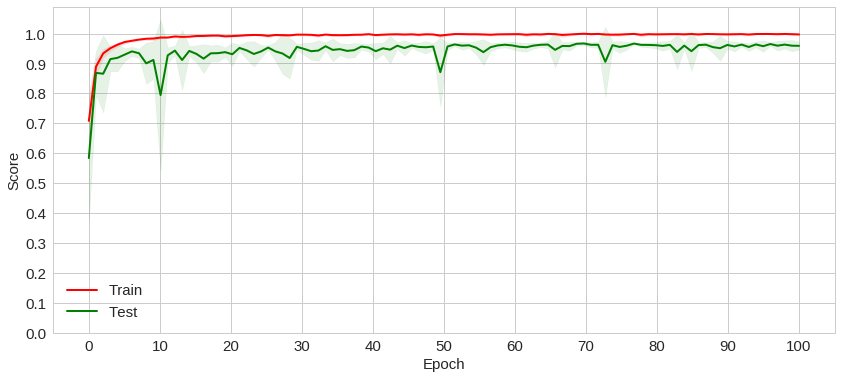

In [28]:
plot_mean_acc(hist)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

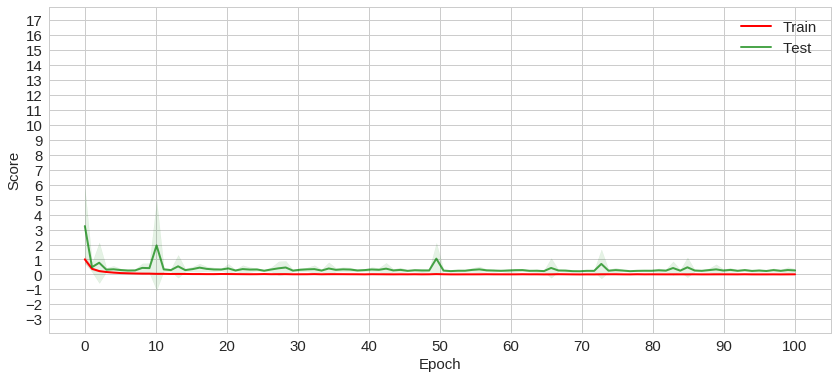

In [30]:
plot_mean_loss(hist)